In [1]:
import os
import sys
import numpy as np
from skimage import io
from scipy import ndimage
from matplotlib import pyplot as plt
import cv2
import SimpleITK as sitk
from tifffile import imwrite

In [2]:
def compare_two_images(img1, img2):
    plt.figure(figsize=[20,20])
    plt.imshow(img1,cmap='Blues')
    plt.imshow(img2,alpha=0.5,cmap='Reds')

In [3]:
DATA = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK52/preps/CH1'
REGDATA = '/net/birdstore/Active_Atlas_Data/data_root/brains_info/registration'

In [31]:
filename = 'allen_25um_sagittal.tif'
fixedFilepath = os.path.join(REGDATA, filename)
fixed_volume = io.imread(fixedFilepath)
fz, fy, fx = fixed_volume.shape
print(f'Fixed volume shape={fixed_volume.shape} dtype={fixed_volume.dtype}')

Fixed volume shape=(456, 320, 528) dtype=uint16


In [33]:
colpad = np.zeros((fixed_volume.shape[0], fixed_volume.shape[1], 200), np.uint16)
print(f'colspad shape={colpad.shape}')
fixed_volume = np.concatenate((fixed_volume, colpad), axis=2)
rowpad = np.zeros((fixed_volume.shape[0], 200, fixed_volume.shape[2]), np.uint16)
print(f'rowpad shape={rowpad.shape}')
fixed_volume = np.concatenate((fixed_volume, rowpad), axis=1)
print(f'Fixed volume after padding shape={fixed_volume.shape} dtype={fixed_image.dtype}')

colspad shape=(456, 320, 200)
rowpad shape=(456, 200, 928)
Fixed volume after padding shape=(456, 520, 928) dtype=uint16


In [34]:
outpath = os.path.join(REGDATA, 'allen_25um_sagittal.tif')
imwrite(outpath, fixed_volume)

In [ ]:
movingFilepath = os.path.join(DATA, 'moving_volume.tif')
moving_volume = io.imread(movingFilepath)
mz, my, mx = moving_volume.shape
print(f'Moving volume shape={moving_volume.shape} dtype={moving_volume.dtype}')

In [ ]:
scales = (fz/mz, fy/my, 1)
scales

In [ ]:
moving_zoom = ndimage.zoom(moving_volume, scales)
del moving_volume
print(moving_zoom.shape, moving_zoom.dtype)

In [ ]:
outpath = os.path.join(DATA, 'moving_zoom.tif')
imwrite(outpath, moving_zoom)

In [17]:
fixed_midpoint = fixed_volume.shape[0] // 2
fixed_image = fixed_volume[fixed_midpoint,:,:]
print(f'Fixed image shape={fixed_image.shape} dtype={fixed_image.dtype}')
colpad = np.zeros((fixed_image.shape[0], 200), np.uint16)
fixed_image = np.hstack((fixed_image, colpad))
rowpad = np.zeros((200,fixed_image.shape[1]), np.uint16)
fixed_image = np.vstack((fixed_image, rowpad))
print(f'Fixed image after padding shape={fixed_image.shape} dtype={fixed_image.dtype}')

Fixed image shape=(320, 528) dtype=uint16
Fixed image after padding shape=(520, 728) dtype=uint16


In [10]:
# moving_volume around x=1200, y = 750 for 10um
# moving volume around x=600, y=350 for 25um
files = os.listdir(os.path.join(DATA, 'thumbnail_aligned'))
midpoint = len(files) // 2
filename = f'{midpoint}.tif'
movingFilepath = os.path.join(DATA, 'thumbnail_aligned', filename)
moving_image = io.imread(movingFilepath)
print(f'Shape of {filename}: {moving_image.shape}')
#moving_image = moving_image[200:-200,200:-200]
print(f'Shape after cropping of {filename}: {moving_image.shape}')

Shape of 243.tif: (555, 1024)
Shape after cropping of 243.tif: (555, 1024)


In [ ]:
fx = 65500
fy = 35500
print(fx/2252)
print(fy/1220)
1/29.85*100

In [ ]:
fixedImage = sitk.ReadImage(fixedFilepath)
movingImage = sitk.ReadImage(movingFilepath)

initial_transform = sitk.CenteredTransformInitializer(fixedImage, 
                                                    movingImage, 
                                                    sitk.Euler3DTransform(), 
                                                    sitk.CenteredTransformInitializerFilter.MOMENTS)

moving_resampled = sitk.Resample(movingImage, fixedImage, initial_transform, sitk.sitkLinear, 0.0, movingImage.GetPixelID())
moving_volume = sitk.GetArrayFromImage(moving_resampled)

In [20]:
fixedImage = sitk.GetImageFromArray(fixed_image)
movingImage = sitk.GetImageFromArray(moving_image)
print(type(fixedImage))

<class 'SimpleITK.SimpleITK.Image'>


In [21]:
%%time
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixedImage)
elastixImageFilter.SetMovingImage(movingImage)
translateParameterMap = sitk.GetDefaultParameterMap('translation')
translateParameterMap["ResultImagePixelType"] = ["unsigned char"]
translateParameterMap["MaximumNumberOfIterations"] = ["15"] # 250 works ok        
rigidParameterMap = sitk.GetDefaultParameterMap('rigid')
rigidParameterMap["ResultImagePixelType"] = ["unsigned char"]
rigidParameterMap["MaximumNumberOfIterations"] = ["1500"] # 250 works ok        
rigidParameterMap["MaximumNumberOfSamplingAttempts"] = ["10"]
rigidParameterMap["UseDirectionCosines"] = ["true"]
rigidParameterMap["NumberOfResolutions"]= ["6"]
rigidParameterMap["NumberOfSpatialSamples"] = ["4000"]
rigidParameterMap["WriteResultImage"] = ["false"]


affineParameterMap = sitk.GetDefaultParameterMap('affine')
affineParameterMap["UseDirectionCosines"] = ["true"]
affineParameterMap["MaximumNumberOfIterations"] = ["1000"] # 250 works ok
affineParameterMap["MaximumNumberOfSamplingAttempts"] = ["10"]
affineParameterMap["NumberOfResolutions"]= ["6"]
affineParameterMap["NumberOfSpatialSamples"] = ["4000"]
affineParameterMap["WriteResultImage"] = ["false"]

bsplineParameterMap = sitk.GetDefaultParameterMap('bspline')
bsplineParameterMap["MaximumNumberOfIterations"] = ["1500"] # 150 works ok
bsplineParameterMap["WriteResultImage"] = ["false"]
bsplineParameterMap["UseDirectionCosines"] = ["true"]
bsplineParameterMap["FinalGridSpacingInVoxels"] = ["10"]
bsplineParameterMap["MaximumNumberOfSamplingAttempts"] = ["10"]
bsplineParameterMap["NumberOfResolutions"]= ["6"]
bsplineParameterMap["GridSpacingSchedule"] = ["6.219", "4.1", "2.8", "1.9", "1.4", "1.0"]
bsplineParameterMap["NumberOfSpatialSamples"] = ["4000"]
del bsplineParameterMap["FinalGridSpacingInPhysicalUnits"]

elastixImageFilter.SetParameterMap(translateParameterMap)
elastixImageFilter.SetParameterMap(rigidParameterMap)
elastixImageFilter.AddParameterMap(affineParameterMap)
#elastixImageFilter.AddParameterMap(bsplineParameterMap)
resultImage = elastixImageFilter.Execute()

Time spent on saving the results, applying the final transform etc.: 30 ms.
ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading images...
Reading images took 0 ms.

  A default pyramid schedule is used.
  A default pyramid schedule is used.
  The default value "false" is used instead.
  The default value "GeometricalCenter" is used instead.
Transform parameters are initialized as: [0, 0, 0]
Scales are estimated automatically.
Scales for transform parameters are: [67353.5, 1, 1]
Initialization of all components (before registration) took: 5 ms.
Preparation of the image pyramids took: 54 ms.

Resolution: 0
  The default value "false" is used instead.
  The default value "true" is used instead.
Setting the fixed masks to

139	-0.128090	0.000000	219.990739	0.001464	0.9
140	-0.138028	0.000000	219.990739	0.002226	1.0
141	-0.132852	0.000000	219.990739	0.000954	1.1
142	-0.132329	0.000000	219.990739	0.001234	1.0
143	-0.142395	0.000000	219.990739	0.001637	1.0
144	-0.138638	0.000000	219.990739	0.001076	1.0
145	-0.133306	0.000000	219.990739	0.001620	0.9
146	-0.152801	0.000000	219.990739	0.001857	0.9
147	-0.132066	0.000000	219.990739	0.002027	0.9
148	-0.125562	0.000000	219.990739	0.001639	0.9
149	-0.146967	0.000000	219.990739	0.002056	1.1
150	-0.156945	0.000000	219.990739	0.000950	1.0
151	-0.140633	0.000000	219.990739	0.001814	1.0
152	-0.156676	0.000000	219.990739	0.001587	1.3
153	-0.136152	0.000000	219.990739	0.001595	1.2
154	-0.139657	0.000000	219.990739	0.000967	1.1
155	-0.135016	0.000000	219.990739	0.000262	1.2
156	-0.144438	0.000000	219.990739	0.001098	1.1
157	-0.134265	0.000000	219.990739	0.001381	1.1
158	-0.144364	0.000000	219.990739	0.001001	1.0
159	-0.134515	0.000000	219.990739	0.002188	1.2
160	-0.151411

356	-0.308740	0.000000	219.990739	0.003494	0.8
357	-0.290460	0.000000	219.990739	0.001251	1.0
358	-0.296260	0.000000	219.990739	0.002381	1.2
359	-0.288546	0.000000	219.990739	0.002325	1.0
360	-0.314921	0.000000	219.990739	0.002482	1.0
361	-0.291333	0.000000	219.990739	0.003826	0.9
362	-0.279056	0.000000	219.990739	0.003907	0.9
363	-0.318788	0.000000	219.990739	0.001501	0.9
364	-0.308548	0.000000	219.990739	0.003718	0.8
365	-0.322440	0.000000	219.990739	0.002539	0.9
366	-0.311060	0.000000	219.990739	0.003931	0.8
367	-0.326116	0.000000	219.990739	0.003242	0.9
368	-0.320145	0.000000	219.990739	0.002649	0.9
369	-0.307653	0.000000	219.990739	0.002508	0.9
370	-0.327725	0.000000	219.990739	0.004114	0.9
371	-0.325761	0.000000	219.990739	0.002869	1.0
372	-0.323330	0.000000	219.990739	0.003257	1.3
373	-0.320684	0.000000	219.990739	0.003269	1.2
374	-0.325464	0.000000	219.990739	0.004110	1.1
375	-0.342173	0.000000	219.990739	0.003144	0.9
376	-0.324339	0.000000	219.990739	0.004542	1.1
377	-0.339730

604	-0.538038	0.000000	219.990739	0.002516	0.8
605	-0.560032	0.000000	219.990739	0.002948	1.0
606	-0.565070	0.000000	219.990739	0.002957	0.9
607	-0.575172	0.000000	219.990739	0.002824	1.4
608	-0.560716	0.000000	219.990739	0.002694	0.9
609	-0.584119	0.000000	219.990739	0.002809	1.0
610	-0.554649	0.000000	219.990739	0.002901	0.9
611	-0.570650	0.000000	219.990739	0.003219	0.9
612	-0.577422	0.000000	219.990739	0.002354	0.8
613	-0.577424	0.000000	219.990739	0.001606	0.8
614	-0.554244	0.000000	219.990739	0.001536	0.8
615	-0.578933	0.000000	219.990739	0.002708	0.9
616	-0.559030	0.000000	219.990739	0.002575	0.8
617	-0.581931	0.000000	219.990739	0.002729	0.9
618	-0.589402	0.000000	219.990739	0.001553	0.8
619	-0.558287	0.000000	219.990739	0.000914	0.9
620	-0.585645	0.000000	219.990739	0.002913	1.0
621	-0.561837	0.000000	219.990739	0.001666	0.9
622	-0.578005	0.000000	219.990739	0.001940	1.1
623	-0.585326	0.999999	209.991174	0.001932	1.0
624	-0.574795	0.586537	214.013273	0.001899	0.9
625	-0.590618

844	-0.628300	0.000000	219.990739	0.002740	1.0
845	-0.625932	0.000000	219.990739	0.001947	0.9
846	-0.629932	0.000000	219.990739	0.000958	1.1
847	-0.633418	0.000000	219.990739	0.001800	1.1
848	-0.644853	0.000000	219.990739	0.000976	1.0
849	-0.619612	0.000000	219.990739	0.001624	1.0
850	-0.634829	0.000000	219.990739	0.002319	0.9
851	-0.633034	0.000000	219.990739	0.003071	1.0
852	-0.626482	0.000000	219.990739	0.002187	0.9
853	-0.615012	0.000000	219.990739	0.001165	0.9
854	-0.641243	0.000000	219.990739	0.001856	1.0
855	-0.645782	0.000000	219.990739	0.001059	0.9
856	-0.647618	0.000000	219.990739	0.002538	1.0
857	-0.633590	0.000000	219.990739	0.001400	0.9
858	-0.643210	0.000000	219.990739	0.002617	0.9
859	-0.650529	0.000000	219.990739	0.002055	0.9
860	-0.655478	0.000000	219.990739	0.001636	1.0
861	-0.614028	0.000000	219.990739	0.001927	1.2
862	-0.633461	0.000000	219.990739	0.001323	1.1
863	-0.634817	0.000000	219.990739	0.002392	1.1
864	-0.662627	0.000000	219.990739	0.002290	0.9
865	-0.625208

1071	-0.661191	42.790759	72.421235	0.000631	0.8
1072	-0.678831	43.786800	71.307821	0.002637	0.8
1073	-0.670218	44.786799	70.223898	0.000639	0.9
1074	-0.666194	45.226828	69.757312	0.001435	1.1
1075	-0.670629	46.221301	68.725321	0.000571	1.0
1076	-0.682019	45.808658	69.149802	0.000282	0.9
1077	-0.671918	45.572340	69.395270	0.000378	1.0
1078	-0.668278	45.318248	69.661152	0.000679	0.9
1079	-0.668680	45.918898	69.035888	0.000772	0.9
1080	-0.687032	45.505568	69.464943	0.000366	0.9
1081	-0.676997	45.094519	69.896953	0.000621	0.8
1082	-0.661833	44.694519	70.322542	0.000421	0.9
1083	-0.678570	45.339272	69.639075	0.001142	0.9
1084	-0.676471	45.002293	69.994622	0.000691	0.9
1085	-0.684321	44.754366	70.258537	0.000837	0.9
1086	-0.676590	45.754313	69.206098	0.002311	0.9
1087	-0.659645	45.340851	69.637417	0.000729	1.0
1088	-0.686417	46.340851	68.603313	0.001210	1.6
1089	-0.678155	47.340833	67.599490	0.000532	1.8
1090	-0.671480	48.339929	66.625472	0.001252	1.2
1091	-0.680990	49.339926	65.678283	0.001

1304	-0.686684	82.740415	44.532360	0.000852	0.9
1305	-0.658943	82.326954	44.710556	0.000089	1.1
1306	-0.663221	82.846128	44.487027	0.000713	1.1
1307	-0.695568	82.598627	44.593308	0.001910	1.0
1308	-0.687013	83.598562	44.167008	0.001203	1.0
1309	-0.671748	83.185101	44.342286	0.001024	1.2
1310	-0.666143	82.771640	44.518960	0.000810	0.9
1311	-0.682060	83.508883	44.204908	0.000787	0.9
1312	-0.676486	84.508860	43.785949	0.001458	0.9
1313	-0.661067	85.508860	43.374847	0.001409	0.9
1314	-0.681937	86.508860	42.971393	0.002993	0.9
1315	-0.670627	87.508860	42.575376	0.001225	0.9
1316	-0.679116	87.095399	42.738225	0.001343	0.9
1317	-0.676425	86.681938	42.902325	0.001787	0.9
1318	-0.679297	87.681938	42.507574	0.000633	1.0
1319	-0.674490	87.345758	42.639468	0.000272	0.9
1320	-0.687397	86.950830	42.795461	0.000821	0.9
1321	-0.678840	87.818071	42.454396	0.000911	1.2
1322	-0.682505	88.818050	42.067816	0.001266	1.1
1323	-0.667964	89.818050	41.688205	0.000423	1.1
1324	-0.677660	90.817966	41.315414	0.000

  Sampling the gradients took 0.015847s
Automatic parameter estimation took 0.02s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.514466	0.000000	99.654656	0.001288	19.3
1	-0.507548	0.000000	99.654656	0.000879	1.0
2	-0.525961	0.994112	95.150364	0.001417	0.9
3	-0.531966	1.683534	92.258453	0.002250	0.9
4	-0.522840	1.140623	94.520726	0.000729	0.9
5	-0.521376	2.120794	90.513665	0.001496	0.9
6	-0.533749	1.321206	93.756034	0.001169	0.9
7	-0.523529	0.542165	97.146587	0.002548	0.9
8	-0.527489	0.000000	99.654656	0.002965	0.9
9	-0.535872	1.000000	95.124899	0.001116	0.9
10	-0.515791	0.192515	98.749382	0.001791	0.9
11	-0.516277	0.000000	99.654656	0.001075	0.9
12	-0.517408	0.000000	99.654656	0.001157	1.0
13	-0.540398	0.000000	99.654656	0.000476	0.9
14	-0.526516	0.000000	99.654656	0.002356	0.9
15	-0.516206	0.000000	99.654656	0.001601	0.9
16	-0.513971	0.000000	99.654656	0.002004	1.1
17	-0.533132	0.999657	95.126383	0.001897	1.3
18	-0.536739	1.998161	90.996309	0.002422	1.6
19	-0.524725

238	-0.534800	21.622107	49.100055	0.000917	0.8
239	-0.533951	21.506264	49.233868	0.001497	0.9
240	-0.536589	22.506038	48.102467	0.002200	1.0
241	-0.523946	23.450997	47.079884	0.000833	1.2
242	-0.535915	22.974319	47.590226	0.000922	1.1
243	-0.528286	22.827462	47.749692	0.001433	1.0
244	-0.525082	23.459170	47.071229	0.001651	0.9
245	-0.545008	24.459168	46.035770	0.000729	0.9
246	-0.539413	25.427375	45.075729	0.002162	1.0
247	-0.545405	26.425597	44.126968	0.002105	0.9
248	-0.534498	27.425597	43.215735	0.002437	0.9
249	-0.520384	26.618091	43.948586	0.000491	0.9
250	-0.516455	25.835619	44.682826	0.000970	0.9
251	-0.546285	25.978059	44.547345	0.001950	0.9
252	-0.511956	26.652579	43.916779	0.001618	0.9
253	-0.507488	25.845071	44.673810	0.001762	0.9
254	-0.516367	25.180337	45.316858	0.000819	0.9
255	-0.508269	24.386896	46.109075	0.002102	1.0
256	-0.510722	23.579725	46.943937	0.000469	1.0
257	-0.519495	22.991781	47.571336	0.001640	1.1
258	-0.536601	22.537840	48.067332	0.000876	1.1
259	-0.528274

476	-0.541324	19.501266	51.671170	0.000992	0.8
477	-0.527913	20.253806	50.728599	0.001254	0.9
478	-0.547751	19.458730	51.725494	0.002155	0.9
479	-0.534384	18.974227	52.352426	0.001472	1.0
480	-0.528043	18.166719	53.431786	0.002164	1.0
481	-0.541839	19.065945	52.232583	0.002183	1.0
482	-0.539511	18.258437	53.306956	0.001214	0.9
483	-0.511624	17.450931	54.426453	0.001274	0.9
484	-0.517795	16.956696	55.135141	0.001950	0.9
485	-0.541979	16.152237	56.328984	0.002947	0.9
486	-0.528158	17.152237	54.852557	0.000829	0.9
487	-0.517441	16.344739	56.038623	0.002355	0.8
488	-0.522988	17.343000	54.579657	0.000462	0.9
489	-0.527614	16.538382	55.749547	0.001415	0.9
490	-0.514228	15.974160	56.600279	0.001555	0.9
491	-0.530528	15.166748	57.863863	0.001792	0.9
492	-0.529008	15.654316	57.094171	0.002486	0.9
493	-0.537776	16.654316	55.577899	0.000643	0.9
494	-0.512635	17.481077	54.383815	0.001852	1.0
495	-0.514572	16.680546	55.539210	0.001429	1.1
496	-0.543790	16.895085	55.224782	0.002272	1.0
497	-0.531616

713	-0.503859	26.066687	44.463460	0.002079	0.8
714	-0.520308	26.990825	43.607248	0.001124	0.9
715	-0.521936	26.183317	44.353554	0.001392	1.1
716	-0.526272	25.375864	45.125796	0.001197	1.0
717	-0.528368	24.749780	45.743340	0.001308	1.0
718	-0.528583	23.942358	46.565153	0.000866	0.9
719	-0.525808	23.175961	47.373000	0.000643	0.9
720	-0.528888	22.403121	48.216527	0.001678	0.9
721	-0.529990	23.400993	47.132905	0.002085	0.8
722	-0.526849	22.708644	47.879495	0.001117	0.8
723	-0.532350	23.708643	46.808573	0.001209	0.9
724	-0.511923	22.901343	47.669334	0.001084	0.9
725	-0.533057	23.899958	46.609126	0.000988	0.9
726	-0.552766	23.094738	47.460261	0.001167	0.9
727	-0.527929	24.084683	46.418154	0.001319	0.9
728	-0.538496	23.496434	47.031809	0.000966	1.0
729	-0.521355	22.689502	47.900472	0.001563	0.9
730	-0.524766	23.689152	46.828988	0.002039	1.1
731	-0.525683	23.230529	47.314554	0.001571	1.0
732	-0.516980	22.423021	48.194430	0.001855	1.1
733	-0.519522	23.422183	47.110422	0.000437	1.2
734	-0.532249

953	-0.512681	46.837578	30.849388	0.001075	0.8
954	-0.512929	47.640810	30.488390	0.001102	1.0
955	-0.511077	48.639818	30.051023	0.001466	1.3
956	-0.512674	47.832580	30.403448	0.001647	1.0
957	-0.517128	47.025072	30.764360	0.000530	1.0
958	-0.530091	48.011481	30.324632	0.001702	1.0
959	-0.544955	48.916333	29.932173	0.002250	0.9
960	-0.508596	48.108825	30.281918	0.000829	0.9
961	-0.519076	49.093608	29.856471	0.001270	0.9
962	-0.531369	48.370529	30.167678	0.001617	1.0
963	-0.513435	47.563024	30.522979	0.000994	0.9
964	-0.518445	46.771869	30.879299	0.001079	0.9
965	-0.509443	47.568443	30.520567	0.001334	1.0
966	-0.530854	48.547782	30.090791	0.003706	0.9
967	-0.524883	49.547782	29.664260	0.000453	0.9
968	-0.526349	48.740294	30.007728	0.000900	1.0
969	-0.522252	48.038299	30.312853	0.001009	0.9
970	-0.527231	48.063970	30.301585	0.000888	1.0
971	-0.542771	49.021875	29.887057	0.000665	1.3
972	-0.529717	49.644083	29.623823	0.002042	1.4
973	-0.522360	49.814782	29.552414	0.001346	1.3
974	-0.526105

1182	-0.502511	60.908495	25.549826	0.001150	1.0
1183	-0.535378	60.102486	25.803744	0.000714	1.4
1184	-0.533610	60.146181	25.789849	0.001713	1.1
1185	-0.524411	61.143216	25.476818	0.001027	1.1
1186	-0.518705	62.104359	25.182166	0.000225	1.0
1187	-0.524004	61.838521	25.262978	0.001133	1.0
1188	-0.514106	62.180739	25.159043	0.002171	1.0
1189	-0.515864	63.078077	24.890529	0.002250	1.0
1190	-0.525634	62.271372	25.131659	0.000358	1.0
1191	-0.531178	61.711652	25.301729	0.001012	1.0
1192	-0.562926	62.214417	25.148861	0.000278	1.0
1193	-0.519216	61.760046	25.286933	0.001932	1.0
1194	-0.514600	61.526491	25.358497	0.000628	1.0
1195	-0.519432	61.453830	25.380844	0.001071	1.1
1196	-0.528662	60.909564	25.549492	0.001784	1.0
1197	-0.527043	61.702239	25.304608	0.001555	1.3
1198	-0.521164	61.970283	25.222859	0.000969	1.0
1199	-0.522623	62.969175	24.922810	0.001481	1.0
1200	-0.535859	63.968987	24.629548	0.000624	1.2
1201	-0.536707	63.166549	24.864365	0.001563	1.0
1202	-0.552290	64.158215	24.574820	0.000

1408	-0.516573	81.121499	20.492725	0.000743	0.8
1409	-0.531563	80.625649	20.592713	0.002312	0.9
1410	-0.527055	81.625528	20.392078	0.001563	1.1
1411	-0.523777	80.818020	20.553806	0.000252	1.2
1412	-0.530129	80.497894	20.618633	0.001523	1.0
1413	-0.513549	80.527807	20.612558	0.001216	0.9
1414	-0.521151	81.520869	20.412895	0.000753	1.0
1415	-0.517002	81.402754	20.436440	0.000486	0.9
1416	-0.527466	80.907247	20.535809	0.001899	0.9
1417	-0.526131	81.814151	20.354667	0.000654	0.9
1418	-0.523207	81.017111	20.513694	0.001880	0.9
1419	-0.532797	81.995882	20.318752	0.001042	0.9
1420	-0.541004	81.188384	20.479312	0.001148	0.9
1421	-0.527798	82.186721	20.281173	0.002134	0.9
1422	-0.532232	82.279283	20.262997	0.000667	0.9
1423	-0.524684	83.064902	20.110025	0.001127	0.9
1424	-0.518771	82.497036	20.220364	0.001561	1.0
1425	-0.522646	83.129655	20.097520	0.002005	0.9
1426	-0.509575	83.808104	19.967423	0.001720	1.1
1427	-0.528590	84.808104	19.778710	0.001141	1.1
1428	-0.525292	84.021253	19.926898	0.001

126	-0.440914	14.068545	41.994623	0.002426	0.8
127	-0.433996	15.068536	40.830333	0.003520	1.0
128	-0.445253	16.068535	39.728852	0.001643	1.0
129	-0.448896	17.068535	38.685238	0.001879	1.1
130	-0.466527	18.067421	37.696123	0.003308	1.0
131	-0.453498	19.067421	36.755306	0.002221	1.0
132	-0.449789	20.067421	35.860307	0.003524	0.9
133	-0.442267	19.224015	36.612216	0.003159	0.9
134	-0.441872	20.224015	35.724088	0.003543	0.9
135	-0.454545	21.224015	34.878027	0.001922	0.9
136	-0.455993	20.514352	35.474246	0.002460	0.9
137	-0.439109	21.514318	34.639868	0.002519	0.9
138	-0.456919	21.188162	34.907668	0.001114	0.9
139	-0.455311	22.175967	34.109030	0.001832	0.9
140	-0.457035	21.688609	34.498439	0.003541	0.9
141	-0.449055	22.688547	33.708842	0.002068	0.9
142	-0.463535	21.845790	34.371880	0.002887	0.9
143	-0.452959	22.845779	33.587961	0.001499	0.9
144	-0.462207	22.063874	34.197814	0.002879	0.9
145	-0.451834	22.929625	33.523854	0.000946	1.0
146	-0.443459	23.895141	32.802890	0.001194	0.9
147	-0.443467

365	-0.462828	10.213443	47.181285	0.003426	0.8
366	-0.450811	9.370036	48.491558	0.002171	0.9
367	-0.433062	10.370036	46.945766	0.000807	1.0
368	-0.455240	10.412452	46.882375	0.004063	1.2
369	-0.441925	9.573180	48.169354	0.003071	1.0
370	-0.441582	10.573155	46.643749	0.001393	1.0
371	-0.446077	9.729748	47.923932	0.000431	0.9
372	-0.453574	9.795893	47.820998	0.003039	0.9
373	-0.441609	8.998543	49.092062	0.004219	0.8
374	-0.467292	8.173385	50.480612	0.001897	0.8
375	-0.465961	7.408832	51.839173	0.001884	1.0
376	-0.454344	8.401214	50.089440	0.001085	0.9
377	-0.463851	9.357238	48.512000	0.002190	1.0
378	-0.444394	8.515542	49.895419	0.001305	0.9
379	-0.452967	9.460976	48.346788	0.001652	0.9
380	-0.457607	8.627039	49.707645	0.001723	0.9
381	-0.449198	9.500318	48.284426	0.001910	0.9
382	-0.462143	8.656918	49.657565	0.002326	1.0
383	-0.458353	7.813511	51.111103	0.002166	1.2
384	-0.447724	6.970104	52.652302	0.002677	1.1
385	-0.450582	6.130011	54.282704	0.002193	1.1
386	-0.465977	5.286604	56.0243

593	-0.443314	18.187958	37.580176	0.003360	0.8
594	-0.450189	17.344550	38.406770	0.002746	1.5
595	-0.443435	17.155361	38.597206	0.001329	1.4
596	-0.448527	16.327399	39.453334	0.001942	1.2
597	-0.451423	15.484242	40.365108	0.000869	1.2
598	-0.456785	15.057762	40.842533	0.001294	1.1
599	-0.452890	15.247181	40.629100	0.003700	1.1
600	-0.446683	16.245998	39.539559	0.003149	1.0
601	-0.457652	17.190048	38.562150	0.001667	0.9
602	-0.446709	16.795048	38.965166	0.001164	1.0
603	-0.439312	15.974583	39.829802	0.002619	0.9
604	-0.482980	15.158288	40.728984	0.002803	0.9
605	-0.450222	14.675350	41.280333	0.000954	0.9
606	-0.455462	13.911512	42.183516	0.001938	1.0
607	-0.443763	14.637821	41.323805	0.003960	1.0
608	-0.450953	13.794413	42.325483	0.003453	0.9
609	-0.449744	14.794413	41.143022	0.001884	0.9
610	-0.445061	13.951006	42.135850	0.001771	1.1
611	-0.457355	14.714958	41.234553	0.002281	1.1
612	-0.449051	13.889523	42.210103	0.002217	1.0
613	-0.453955	13.046115	43.255752	0.001305	1.1
614	-0.447161

824	-0.451446	47.644886	21.453752	0.000540	0.8
825	-0.447967	48.630839	21.149972	0.001804	0.9
826	-0.442580	47.909320	21.371425	0.000937	1.0
827	-0.451630	47.072102	21.634271	0.006698	1.1
828	-0.458653	48.072102	21.321059	0.002955	1.0
829	-0.432753	49.072102	21.016785	0.004371	0.9
830	-0.439272	48.234159	21.271152	0.001884	0.9
831	-0.463000	47.390751	21.533472	0.001227	0.9
832	-0.451411	47.497385	21.499950	0.001907	1.2
833	-0.455314	46.666210	21.764043	0.001945	1.0
834	-0.435153	47.666204	21.447091	0.002354	1.0
835	-0.431309	48.665184	21.139546	0.000889	1.0
836	-0.458403	49.658629	20.842328	0.001575	1.1
837	-0.455843	48.821654	21.092172	0.000581	1.0
838	-0.437147	49.625999	20.851958	0.002432	1.0
839	-0.460580	50.537863	20.586166	0.001877	1.0
840	-0.442234	49.694457	20.831765	0.000738	1.0
841	-0.447589	50.278947	20.660944	0.003268	1.3
842	-0.446924	51.278694	20.375165	0.001271	1.1
843	-0.429823	52.278677	20.097120	0.000499	1.2
844	-0.449042	52.632240	20.000618	0.003417	1.0
845	-0.448062

1059	-0.446346	63.647187	17.397983	0.002595	0.8
1060	-0.445944	64.647187	17.194848	0.003261	1.0
1061	-0.445269	65.546602	17.016154	0.000647	0.9
1062	-0.461237	66.526139	16.825720	0.001585	1.1
1063	-0.467386	65.775833	16.971204	0.002605	1.2
1064	-0.449705	64.932428	17.137772	0.001203	1.1
1065	-0.445299	64.267108	17.271494	0.001211	1.0
1066	-0.433310	65.020886	17.120148	0.002676	1.0
1067	-0.447698	66.020485	16.923490	0.001570	0.9
1068	-0.441247	67.012475	16.732745	0.003109	0.9
1069	-0.455796	66.174848	16.893523	0.002766	0.9
1070	-0.442831	65.331441	17.058563	0.001545	0.9
1071	-0.448404	64.488033	17.226859	0.002202	1.0
1072	-0.437025	65.470626	17.031105	0.001502	1.0
1073	-0.447502	64.660788	17.192117	0.002815	1.0
1074	-0.458129	65.660729	16.993745	0.001369	1.0
1075	-0.453210	64.818814	17.160460	0.002886	0.9
1076	-0.450325	65.716780	16.982761	0.004198	0.9
1077	-0.451162	66.716780	16.789152	0.000827	1.0
1078	-0.460264	67.716773	16.599909	0.000952	1.2
1079	-0.438386	67.146079	16.707383	0.001

1286	-0.456004	81.806078	14.324935	0.001915	0.8
1287	-0.464490	82.806077	14.186938	0.001335	1.0
1288	-0.455814	83.781264	14.054902	0.001749	1.1
1289	-0.453715	82.937984	14.168933	0.001106	1.1
1290	-0.458611	83.927366	14.035331	0.002410	1.0
1291	-0.451816	84.923577	13.903329	0.003935	1.0
1292	-0.438102	85.922888	13.773387	0.002606	1.0
1293	-0.450667	85.079518	13.882891	0.000596	1.0
1294	-0.441371	84.239950	13.993644	0.002160	0.9
1295	-0.452000	83.483432	14.094965	0.001543	1.0
1296	-0.445190	82.643304	14.209218	0.002949	0.9
1297	-0.439813	83.643287	14.073433	0.002865	0.9
1298	-0.463625	82.801155	14.187610	0.001857	0.9
1299	-0.443438	83.801154	14.052234	0.002198	1.0
1300	-0.440298	84.801148	13.919417	0.003698	0.9
1301	-0.432296	85.801043	13.789101	0.002487	1.0
1302	-0.439666	84.957636	13.898860	0.002067	0.9
1303	-0.451367	84.114229	14.010381	0.002761	1.0
1304	-0.435993	83.270822	14.123705	0.001751	1.1
1305	-0.463058	82.429976	14.238525	0.001387	1.1
1306	-0.446365	81.679086	14.342651	0.001

2	-0.413474	0.000000	36.968015	0.007112	0.8
3	-0.428327	0.999221	35.288900	0.006286	0.9
4	-0.415099	0.226352	36.573798	0.003003	0.9
5	-0.402330	0.582485	35.970292	0.002026	1.1
6	-0.397826	0.000000	36.968015	0.003255	1.0
7	-0.395141	0.862979	35.508808	0.007638	1.0
8	-0.412710	0.090115	36.810057	0.003589	0.9
9	-0.405021	1.090115	35.143698	0.007705	0.9
10	-0.407264	2.090052	33.621765	0.003907	0.9
11	-0.417215	1.490773	34.517635	0.002806	0.9
12	-0.418316	0.722474	35.738484	0.003341	1.0
13	-0.418912	1.685476	34.221381	0.004614	0.9
14	-0.402472	0.912844	35.428004	0.001239	0.9
15	-0.412748	1.110419	35.111425	0.001883	0.9
16	-0.418751	1.664703	34.252745	0.002276	0.9
17	-0.430532	2.555466	32.957458	0.002188	0.9
18	-0.412816	1.839224	33.991011	0.001579	0.9
19	-0.409503	2.332839	33.271918	0.002391	0.9
20	-0.420699	2.767232	32.663808	0.005110	0.9
21	-0.407458	3.766908	31.345387	0.001842	0.9
22	-0.425994	4.764851	30.131294	0.002317	0.9
23	-0.423278	5.660508	29.119036	0.008784	0.9
24	-0.421285	6.660

223	-0.400295	17.105686	20.373031	0.002382	0.8
224	-0.403918	18.102996	19.853423	0.005251	1.0
225	-0.408774	19.077171	19.370836	0.001992	1.0
226	-0.403668	20.009282	18.930551	0.002952	1.1
227	-0.422254	20.513307	18.700710	0.003483	1.1
228	-0.404347	19.888716	18.986370	0.003819	1.1
229	-0.420969	19.163807	19.329052	0.004339	1.0
230	-0.429858	18.393199	19.707166	0.003915	0.9
231	-0.407075	19.392945	19.219404	0.006911	1.0
232	-0.402572	20.102224	18.887744	0.002544	0.9
233	-0.415595	19.331684	19.248596	0.006293	0.9
234	-0.401530	19.906718	18.978015	0.005103	0.9
235	-0.424898	19.133849	19.343480	0.001516	1.0
236	-0.422793	18.383471	19.712034	0.007757	0.9
237	-0.425790	19.257268	19.284178	0.001554	1.0
238	-0.422824	20.255160	18.817726	0.007863	1.0
239	-0.418720	19.551827	19.144102	0.002279	1.0
240	-0.431132	20.545536	18.686203	0.003911	1.3
241	-0.410022	19.779188	19.037366	0.002012	1.2
242	-0.407940	19.344982	19.242252	0.001211	1.3
243	-0.432070	18.971259	19.422163	0.003968	1.0
244	-0.407200

461	-0.426211	35.824599	13.661835	0.003638	0.8
462	-0.396852	35.051927	13.850163	0.003000	1.0
463	-0.421297	34.449858	14.000546	0.006118	1.1
464	-0.409292	33.677825	14.198230	0.003703	1.1
465	-0.412890	32.904956	14.401798	0.001574	1.0
466	-0.419473	32.623698	14.477336	0.002951	1.0
467	-0.410380	32.927433	14.395796	0.002823	0.9
468	-0.423455	33.888691	14.143684	0.004607	0.9
469	-0.407894	33.148707	14.336968	0.001364	0.9
470	-0.416335	32.869232	14.411349	0.002649	0.9
471	-0.408780	33.742139	14.181549	0.003049	0.9
472	-0.400924	32.977907	14.382335	0.002672	0.9
473	-0.403321	32.215602	14.588359	0.001445	0.9
474	-0.413544	31.656982	14.743122	0.004084	0.8
475	-0.427461	30.954625	14.942429	0.003439	1.0
476	-0.406747	30.217240	15.157558	0.005754	1.0
477	-0.410506	29.445990	15.389297	0.001997	0.9
478	-0.412917	29.338840	15.422054	0.005776	0.9
479	-0.430593	28.566449	15.662375	0.001349	0.9
480	-0.430158	27.797277	15.909255	0.001697	1.1
481	-0.421486	27.611973	15.969899	0.005722	1.0
482	-0.401166

684	-0.413679	33.396309	14.271709	0.004549	0.8
685	-0.427337	32.623832	14.477300	0.001639	0.9
686	-0.416142	31.906515	14.673586	0.007871	1.1
687	-0.419671	32.382706	14.542693	0.001768	1.1
688	-0.408004	33.361956	14.280728	0.000197	1.0
689	-0.402592	33.423663	14.264536	0.008187	1.0
690	-0.388998	33.401444	14.270362	0.003481	0.9
691	-0.423345	32.628575	14.476020	0.002456	0.9
692	-0.422536	31.901113	14.675085	0.002616	0.9
693	-0.419249	31.174475	14.879466	0.001984	0.9
694	-0.440589	31.282591	14.848696	0.001912	0.9
695	-0.436267	32.101933	14.619587	0.007708	0.9
696	-0.417317	33.089835	14.352573	0.001503	0.9
697	-0.417387	34.036199	14.105776	0.003781	0.9
698	-0.404232	34.289072	14.041261	0.002437	0.9
699	-0.424277	35.285801	13.792614	0.002134	0.9
700	-0.409054	36.170695	13.579130	0.002458	0.8
701	-0.401600	35.765269	13.676114	0.002631	0.9
702	-0.410855	36.733724	13.446704	0.005005	1.1
703	-0.412469	37.707754	13.223608	0.002682	1.2
704	-0.415644	37.036495	13.376554	0.007555	1.2
705	-0.421159

922	-0.409635	55.310292	10.173311	0.004171	0.8
923	-0.413987	54.537423	10.277400	0.005434	1.0
924	-0.424658	55.537271	10.143141	0.005228	1.4
925	-0.405575	54.764406	10.246610	0.002710	1.0
926	-0.416379	55.764378	10.113132	0.001870	1.0
927	-0.419537	55.046636	10.208582	0.005428	0.9
928	-0.415976	54.276100	10.313078	0.004743	0.9
929	-0.438437	55.276100	10.177871	0.005905	0.9
930	-0.409698	54.503231	10.282054	0.005375	0.9
931	-0.415238	55.367894	10.165637	0.002793	0.9
932	-0.435082	56.029520	10.078322	0.005532	0.9
933	-0.428930	57.029438	9.949172	0.002578	0.9
934	-0.426926	57.972590	9.830351	0.004011	0.9
935	-0.418748	58.818444	9.726177	0.004268	0.9
936	-0.413881	58.046047	9.821216	0.001257	1.0
937	-0.418477	58.571130	9.756407	0.002191	0.9
938	-0.409941	58.460321	9.770012	0.004678	1.0
939	-0.422897	57.696175	9.864880	0.002216	1.2
940	-0.426874	56.952516	9.958990	0.002212	1.4
941	-0.422399	56.204489	10.055482	0.002621	1.6
942	-0.416790	57.134996	9.935731	0.004162	1.1
943	-0.429175	57.45917

1151	-0.411858	83.655078	7.417971	0.003797	0.8
1152	-0.421004	82.883010	7.473102	0.002295	0.9
1153	-0.427432	82.482773	7.502005	0.005867	1.0
1154	-0.425488	83.120660	7.456045	0.004282	1.1
1155	-0.425990	82.348023	7.511787	0.003754	1.1
1156	-0.403848	81.575157	7.568385	0.003480	1.2
1157	-0.420347	81.553551	7.569980	0.003045	1.0
1158	-0.405054	82.542301	7.497692	0.002081	0.9
1159	-0.402290	81.782258	7.553135	0.003357	1.0
1160	-0.401415	82.384090	7.509166	0.003883	0.9
1161	-0.412544	83.384025	7.437233	0.003685	0.9
1162	-0.408792	84.381343	7.366848	0.001310	0.9
1163	-0.427652	83.682380	7.416036	0.005241	0.9
1164	-0.426703	83.211665	7.449534	0.001809	0.9
1165	-0.417693	82.478344	7.502326	0.002412	0.9
1166	-0.414598	81.764934	7.554409	0.002126	0.9
1167	-0.417661	82.570110	7.495679	0.002399	0.9
1168	-0.409253	81.985632	7.538220	0.002414	0.9
1169	-0.420225	82.490942	7.501413	0.002824	1.8
1170	-0.405976	81.750182	7.555493	0.003435	1.5
1171	-0.417077	80.979759	7.612572	0.006289	1.2
1172	-0.40496

1388	-0.408574	113.267824	5.781939	0.004130	0.8
1389	-0.428575	114.266625	5.739245	0.004718	0.9
1390	-0.420434	113.493958	5.772217	0.002175	1.1
1391	-0.388508	114.142986	5.744496	0.006242	1.3
1392	-0.424254	113.370356	5.777527	0.002758	1.1
1393	-0.421985	112.597747	5.810939	0.005294	1.0
1394	-0.431429	112.773934	5.803285	0.002205	0.9
1395	-0.407991	113.740319	5.761663	0.001906	0.9
1396	-0.403659	114.214831	5.741443	0.003217	1.0
1397	-0.423157	115.043954	5.706452	0.002390	0.9
1398	-0.389475	114.274619	5.738906	0.001639	1.0
1399	-0.421877	115.169973	5.701171	0.004997	1.0
1400	-0.425997	116.113701	5.661931	0.002511	0.9
1401	-0.415155	116.109856	5.662090	0.005798	1.0
1402	-0.413935	117.102857	5.621378	0.001295	1.2
1403	-0.405763	117.881643	5.589855	0.001635	1.0
1404	-0.403425	117.649308	5.599222	0.003882	0.9
1405	-0.400459	118.628305	5.559964	0.001839	1.0
1406	-0.406342	119.607961	5.521226	0.004047	1.2
1407	-0.414064	119.632488	5.520263	0.004166	1.0
1408	-0.417488	120.632315	5.481294	0.001

89	-0.374957	10.584581	13.581058	0.004996	1.0
90	-0.401818	11.584081	13.164466	0.009449	1.4
91	-0.388103	12.578224	12.774709	0.010648	1.0
92	-0.397556	11.815955	13.071448	0.003116	1.0
93	-0.399549	11.336120	13.265414	0.007602	0.9
94	-0.398675	10.641246	13.556736	0.003540	1.0
95	-0.380528	11.369862	13.251587	0.006306	0.9
96	-0.377763	11.508048	13.195256	0.001934	0.9
97	-0.396060	10.871316	13.458874	0.003270	1.0
98	-0.397894	10.778883	13.498021	0.007111	1.0
99	-0.387748	11.309121	13.276499	0.008535	0.9
100	-0.397119	10.560723	13.591325	0.008546	0.9
101	-0.392756	9.798454	13.927713	0.005356	0.9
102	-0.394024	9.055052	14.272210	0.005351	0.9
103	-0.386946	10.010295	13.832568	0.002815	0.9
104	-0.391832	10.170165	13.761622	0.011179	0.9
105	-0.378589	9.748320	13.950422	0.003285	0.9
106	-0.387474	10.720574	13.522833	0.002716	0.9
107	-0.380807	10.850913	13.467495	0.005049	0.9
108	-0.396851	10.177959	13.758182	0.004614	1.0
109	-0.390744	9.434096	14.094456	0.001587	1.1
110	-0.396039	9.050958	14.27

317	-0.381183	31.374718	8.190059	0.007316	0.8
318	-0.388924	31.808419	8.122796	0.006389	1.1
319	-0.377370	31.046492	8.241709	0.003534	1.2
320	-0.383030	30.290044	8.363261	0.003664	1.1
321	-0.382463	30.052519	8.402172	0.004775	0.9
322	-0.387950	30.360426	8.351800	0.005010	0.9
323	-0.379741	30.267592	8.366924	0.004448	0.9
324	-0.394874	29.957952	8.417764	0.008011	0.9
325	-0.395544	29.196668	8.545428	0.007439	0.9
326	-0.389996	30.193772	8.378989	0.001552	0.9
327	-0.397039	29.549096	8.485850	0.010150	0.9
328	-0.377941	30.315860	8.359054	0.003185	1.0
329	-0.405518	31.309431	8.200281	0.005470	1.0
330	-0.408247	30.613144	8.310907	0.008698	1.0
331	-0.380753	30.949634	8.257075	0.004500	0.9
332	-0.384433	30.423349	8.341581	0.007032	0.9
333	-0.388959	31.381469	8.189003	0.008873	0.9
334	-0.383289	30.740463	8.290456	0.001362	1.0
335	-0.391160	30.070169	8.399268	0.007704	1.0
336	-0.388840	29.488265	8.496074	0.006917	1.0
337	-0.393731	30.487710	8.331154	0.003747	1.1
338	-0.369648	29.915128	8.424844	0

550	-0.389281	51.760077	5.895431	0.008350	0.8
551	-0.379539	52.760072	5.815504	0.004669	0.9
552	-0.390245	53.666865	5.744878	0.007144	1.0
553	-0.376448	52.945607	5.800913	0.006157	1.0
554	-0.385376	53.174210	5.783035	0.004347	1.2
555	-0.405692	52.415630	5.842789	0.005300	1.1
556	-0.378189	52.482721	5.837454	0.006882	1.0
557	-0.387557	52.295599	5.852357	0.004290	1.0
558	-0.394302	53.269338	5.775628	0.005084	1.0
559	-0.385935	52.514428	5.834937	0.002692	1.0
560	-0.376426	53.434417	5.762818	0.006336	1.0
561	-0.390760	54.397149	5.689234	0.003295	1.4
562	-0.377939	54.909823	5.650811	0.006147	1.1
563	-0.394950	54.448741	5.685344	0.007207	1.0
564	-0.395876	53.686509	5.743367	0.007339	1.0
565	-0.397535	54.686259	5.667502	0.006636	1.0
566	-0.397875	55.683503	5.593798	0.008119	1.0
567	-0.380978	56.679925	5.522045	0.003525	1.1
568	-0.387491	55.927101	5.576085	0.004015	1.5
569	-0.402352	56.724067	5.518909	0.003660	1.1
570	-0.388034	56.295332	5.549520	0.003948	1.2
571	-0.376635	56.971509	5.501394	0

776	-0.396491	57.084430	5.493439	0.004933	1.4
777	-0.400071	56.322606	5.547563	0.007234	1.2
778	-0.379018	55.575671	5.601675	0.006086	1.1
779	-0.398760	56.574384	5.529558	0.004651	1.0
780	-0.397252	55.898066	5.578190	0.009011	0.9
781	-0.379912	55.216536	5.628070	0.002967	0.9
782	-0.388608	55.930564	5.575834	0.004660	0.9
783	-0.366965	55.296680	5.622159	0.003048	0.9
784	-0.381572	54.683978	5.667673	0.004682	0.8
785	-0.385541	54.722948	5.664756	0.005344	0.9
786	-0.378388	53.966915	5.721885	0.004818	0.9
787	-0.414989	54.929656	5.649335	0.006534	0.9
788	-0.382125	54.168883	5.706511	0.005588	0.9
789	-0.393883	55.163989	5.631953	0.005511	0.9
790	-0.391523	54.510038	5.680729	0.009414	0.9
791	-0.388806	55.425485	5.612683	0.006517	0.9
792	-0.392751	56.404038	5.541727	0.005567	0.9
793	-0.406011	55.642474	5.596793	0.005338	1.0
794	-0.402716	54.892778	5.652080	0.005140	1.1
795	-0.392173	54.692671	5.667022	0.005261	1.0
796	-0.386274	55.547007	5.603773	0.002377	1.3
797	-0.392019	54.854588	5.654925	0

1002	-0.398149	70.914665	4.666851	0.004458	0.9
1003	-0.384585	71.421877	4.641239	0.007061	1.1
1004	-0.405420	72.420223	4.591640	0.004461	1.1
1005	-0.403022	71.927972	4.615962	0.001917	1.1
1006	-0.396092	71.597782	4.632422	0.002833	1.1
1007	-0.391794	71.649346	4.629844	0.005542	1.0
1008	-0.382755	72.505997	4.587428	0.003254	1.0
1009	-0.417347	71.833298	4.620670	0.001483	1.0
1010	-0.416098	71.557231	4.634452	0.007014	1.0
1011	-0.405638	71.061052	4.659430	0.002955	0.9
1012	-0.379598	70.758339	4.674802	0.003084	0.9
1013	-0.413880	70.506832	4.687650	0.003751	0.9
1014	-0.392172	71.156908	4.654584	0.004722	1.0
1015	-0.382937	70.412847	4.692470	0.007067	0.9
1016	-0.389610	71.412187	4.641726	0.004500	1.0
1017	-0.401095	70.657256	4.679957	0.003425	1.0
1018	-0.385477	71.466698	4.638989	0.005947	0.9
1019	-0.395304	72.187997	4.603082	0.009014	0.9
1020	-0.392087	71.425734	4.641045	0.004265	1.0
1021	-0.382601	70.708775	4.677328	0.004794	1.1
1022	-0.406148	70.785155	4.673436	0.004525	1.2
1023	-0.40931

1218	-0.403617	98.926070	3.576804	0.000446	0.9
1219	-0.403983	98.902747	3.577500	0.002872	2.1
1220	-0.388432	98.818983	3.580001	0.005583	1.0
1221	-0.400330	98.087342	3.601995	0.004305	1.0
1222	-0.383191	97.438320	3.621733	0.005012	1.0
1223	-0.400065	96.708867	3.644178	0.005531	1.0
1224	-0.404387	97.701916	3.613691	0.007461	1.0
1225	-0.391825	98.701791	3.583506	0.003629	1.0
1226	-0.402890	99.349424	3.564222	0.006091	0.9
1227	-0.403873	98.600676	3.586535	0.006625	1.0
1228	-0.388910	99.596145	3.556930	0.012133	0.9
1229	-0.391766	100.596119	3.527679	0.001686	1.0
1230	-0.380066	100.876402	3.519566	0.003855	1.0
1231	-0.406050	101.369531	3.505383	0.004743	0.9
1232	-0.397142	102.328192	3.478134	0.005401	0.9
1233	-0.376738	103.323932	3.450277	0.003094	0.9
1234	-0.397594	104.273540	3.424123	0.012960	1.1
1235	-0.371738	103.522435	3.444777	0.002258	1.3
1236	-0.385502	104.517939	3.417456	0.009144	1.0
1237	-0.417830	104.712104	3.412178	0.005216	1.1
1238	-0.388402	104.006248	3.431445	0.007832	1.0
123

1434	-0.392215	133.403163	2.778130	0.008211	0.9
1435	-0.398494	134.402366	2.760267	0.002542	1.0
1436	-0.386493	135.100899	2.747915	0.004744	0.9
1437	-0.400971	134.418520	2.759980	0.003675	1.1
1438	-0.397804	135.385760	2.742910	0.004860	1.1
1439	-0.395091	135.733480	2.736825	0.005619	1.0
1440	-0.384380	136.729252	2.719546	0.005262	1.0
1441	-0.379511	136.627589	2.721300	0.008624	1.0
1442	-0.366039	135.865465	2.734522	0.003171	0.9
1443	-0.394756	135.527901	2.740419	0.007917	1.0
1444	-0.401648	136.508363	2.723360	0.006329	0.9
1445	-0.389783	135.746113	2.736604	0.006813	1.0
1446	-0.411827	136.740705	2.719349	0.004324	1.0
1447	-0.382861	137.586634	2.704844	0.007775	1.0
1448	-0.397051	136.833442	2.717751	0.006282	1.0
1449	-0.390205	136.071209	2.730940	0.006591	1.0
1450	-0.395016	137.071018	2.713667	0.002882	0.9
1451	-0.378641	136.356802	2.725983	0.005068	1.0
1452	-0.392794	136.790680	2.718488	0.003808	1.2
1453	-0.419776	137.673569	2.703362	0.007695	1.1
1454	-0.399882	138.667963	2.686525	0.003

139	-0.367577	19.635227	6.105804	0.001862	0.8
140	-0.372196	19.432938	6.136352	0.014433	0.9
141	-0.357460	19.378056	6.144692	0.006553	0.9
142	-0.386038	20.358402	5.999041	0.014566	1.1
143	-0.381857	19.963261	6.056909	0.012551	1.2
144	-0.380911	20.960889	5.912905	0.007668	1.0
145	-0.385995	20.546467	5.971885	0.007648	1.6
146	-0.367090	20.251771	6.014548	0.012571	1.0
147	-0.387046	19.718641	6.093296	0.005620	0.9
148	-0.361809	19.111605	6.185510	0.002086	0.9
149	-0.385409	19.172999	6.176057	0.009756	1.0
150	-0.386961	19.462946	6.131801	0.014254	0.9
151	-0.371839	20.040229	6.045549	0.012066	0.9
152	-0.356309	19.421053	6.138156	0.005942	0.9
153	-0.371012	18.901192	6.218129	0.007970	1.0
154	-0.374192	18.692542	6.250815	0.010903	1.1
155	-0.383402	18.079860	6.348813	0.003712	1.0
156	-0.356108	17.545240	6.436871	0.013102	0.9
157	-0.385936	17.477297	6.448237	0.007391	1.0
158	-0.388442	17.183325	6.497882	0.006949	0.9
159	-0.370025	17.583987	6.430407	0.016609	1.0
160	-0.358294	16.982052	6.532315	0

373	-0.369888	43.663677	3.836941	0.011911	0.8
374	-0.373265	43.976590	3.818464	0.013072	0.9
375	-0.379494	44.599085	3.782229	0.006668	1.0
376	-0.381091	45.585024	3.726224	0.009657	1.1
377	-0.373927	46.136554	3.695613	0.008316	1.0
378	-0.378281	47.118184	3.642357	0.012676	1.0
379	-0.385033	46.588861	3.670882	0.010485	0.9
380	-0.378072	45.970205	3.704793	0.012449	0.9
381	-0.351474	46.801195	3.659386	0.015665	0.9
382	-0.372665	47.216389	3.637113	0.003823	0.9
383	-0.379085	47.500525	3.622027	0.007065	0.9
384	-0.373046	47.419374	3.626323	0.003827	0.8
385	-0.363639	47.487238	3.622729	0.007156	0.9
386	-0.364829	47.421485	3.626211	0.016927	0.9
387	-0.369196	46.818195	3.658469	0.012684	0.9
388	-0.371775	47.818046	3.605315	0.008255	0.9
389	-0.362096	47.223579	3.636730	0.004690	0.9
390	-0.382201	48.007911	3.595396	0.002984	0.9
391	-0.357433	47.975254	3.597098	0.009434	0.9
392	-0.384370	47.812642	3.605598	0.004647	0.9
393	-0.377860	48.650652	3.562217	0.010191	0.9
394	-0.382741	48.122013	3.589461	0

613	-0.370639	84.564153	2.350331	0.011665	1.0
614	-0.369460	83.944939	2.364199	0.006551	1.0
615	-0.369038	84.920625	2.342421	0.008496	1.2
616	-0.361556	84.873102	2.343473	0.023117	1.3
617	-0.395116	85.645619	2.326497	0.011264	1.1
618	-0.400314	86.645619	2.304885	0.034187	1.0
619	-0.384272	87.645619	2.283670	0.005172	0.9
620	-0.373801	87.026622	2.296756	0.009891	1.0
621	-0.365828	86.667969	2.304406	0.008379	0.9
622	-0.372870	86.060526	2.317481	0.024218	0.9
623	-0.359218	85.441320	2.330963	0.004872	0.9
624	-0.387096	84.892444	2.343045	0.023701	1.0
625	-0.364142	85.736332	2.324520	0.010936	1.0
626	-0.375976	86.682256	2.304100	0.004527	0.9
627	-0.367729	86.247292	2.313445	0.007702	1.0
628	-0.371134	85.929178	2.320328	0.001868	1.1
629	-0.383743	86.183889	2.314814	0.010144	1.0
630	-0.354456	86.249669	2.313394	0.014083	1.1
631	-0.362851	85.898454	2.320995	0.009371	1.6
632	-0.375815	85.280593	2.334488	0.009794	1.3
633	-0.378330	85.387165	2.332149	0.008365	2.3
634	-0.386323	86.226165	2.313901	0

841	-0.347657	96.910389	2.104231	0.017546	0.9
842	-0.386487	97.910358	2.086536	0.014079	0.9
843	-0.385094	97.291145	2.097458	0.016147	1.0
844	-0.368389	96.796006	2.106275	0.012163	1.3
845	-0.378370	96.179661	2.117353	0.003586	1.1
846	-0.357793	96.932907	2.103830	0.014267	1.1
847	-0.361511	96.408268	2.113231	0.006331	1.0
848	-0.378683	96.378005	2.113775	0.012929	1.0
849	-0.379359	96.490882	2.111745	0.007635	1.0
850	-0.395513	97.117341	2.100545	0.014998	0.9
851	-0.379287	96.500348	2.111574	0.022803	0.9
852	-0.383444	97.500297	2.093756	0.009746	0.9
853	-0.378652	98.500288	2.076235	0.032498	1.0
854	-0.395628	99.500188	2.059007	0.015446	1.0
855	-0.376391	100.498892	2.042082	0.007137	1.0
856	-0.387040	99.881115	2.052519	0.011060	1.0
857	-0.371890	99.320518	2.062082	0.005932	1.0
858	-0.373930	99.280435	2.062769	0.017397	1.0
859	-0.382748	100.203902	2.047052	0.015265	1.1
860	-0.375822	101.203899	2.030301	0.011685	1.1
861	-0.379033	102.153031	2.014654	0.012663	1.2
862	-0.379812	103.149625	1.998

1065	-0.386947	116.329250	1.806685	0.002693	1.0
1066	-0.388519	116.339563	1.806550	0.004919	1.2
1067	-0.375099	116.256859	1.807638	0.009570	1.3
1068	-0.380993	116.857185	1.799766	0.006992	1.1
1069	-0.377671	116.259747	1.807600	0.011721	1.1
1070	-0.370742	116.166221	1.808833	0.007769	1.1
1071	-0.375642	117.152778	1.795916	0.020751	1.1
1072	-0.404283	116.535323	1.803978	0.006253	1.0
1073	-0.385672	115.924165	1.812030	0.012031	1.1
1074	-0.378958	115.343493	1.819748	0.001230	1.0
1075	-0.359446	115.531538	1.817241	0.003611	1.0
1076	-0.373836	115.614419	1.816139	0.012814	1.1
1077	-0.391237	115.327827	1.819957	0.016559	1.1
1078	-0.352232	116.327803	1.806704	0.003092	1.1
1079	-0.379044	117.051422	1.797234	0.011866	1.1
1080	-0.358608	116.552398	1.803754	0.008320	1.0
1081	-0.370947	115.994389	1.811101	0.010943	1.1
1082	-0.375211	116.652663	1.802441	0.010920	1.2
1083	-0.374777	116.034202	1.810575	0.011574	1.3
1084	-0.369554	115.415779	1.818783	0.005006	1.2
1085	-0.385471	115.272114	1.820701	0.009

1290	-0.375991	140.152423	1.539603	0.010996	0.8
1291	-0.379490	141.152227	1.530110	0.012514	0.9
1292	-0.386461	140.533649	1.535969	0.004944	1.8
1293	-0.363592	141.401089	1.527765	0.003283	1.0
1294	-0.380229	141.265229	1.529044	0.006418	1.0
1295	-0.374283	141.608595	1.525816	0.016119	1.0
1296	-0.378097	142.596951	1.516598	0.016821	0.8
1297	-0.386930	143.596951	1.507384	0.009978	0.9
1298	-0.383413	144.595848	1.498291	0.009660	1.0
1299	-0.376718	144.997837	1.494662	0.007602	0.9
1300	-0.377782	145.926587	1.486346	0.003716	0.9
1301	-0.376834	145.969363	1.485966	0.005011	1.0
1302	-0.379447	145.729522	1.488103	0.012663	0.9
1303	-0.355488	145.207037	1.492781	0.015452	0.9
1304	-0.379726	146.163687	1.484238	0.018278	0.9
1305	-0.375301	145.546440	1.489739	0.003052	0.9
1306	-0.369913	145.120695	1.493557	0.008111	0.9
1307	-0.363476	145.206257	1.492788	0.010541	0.9
1308	-0.373280	144.692114	1.497420	0.008128	0.9
1309	-0.358733	144.085191	1.502925	0.006015	1.4
1310	-0.396088	143.819158	1.505351	0.011

Initialization of all components (before registration) took: 4 ms.
Preparation of the image pyramids took: 48 ms.

Resolution: 0
  The default value "false" is used instead.
  The default value "true" is used instead.
Setting the fixed masks took: 0 ms.
Setting the moving masks took: 0 ms.
  The default value "1" is used instead.
  The default value "false" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "0.01" is used instead.
  The default value "0.01" is used instead.
  The default value "0" is used instead.
  The default value "3" is used instead.
  The default value "true" is used instead.
  The default value "false" is used instead.
  The default value "false" is used instead.
  The default value "20" is used instead.

  This functionality is known to cause problems (stack overflow) for large values.
  If elastix stops or segfaults for no obvious reason, reduce this 

212	-0.764156	6.960685	58.902829	0.001255	0.8
213	-0.751063	6.846310	59.144765	0.002083	1.1
214	-0.740826	6.731935	59.388696	0.001968	1.2
215	-0.761280	6.617559	59.634648	0.003433	1.1
216	-0.723390	7.612511	57.560954	0.001383	1.0
217	-0.750034	7.498136	57.791971	0.001835	1.2
218	-0.752173	7.383761	58.024850	0.002184	1.0
219	-0.768873	8.383761	56.050124	0.001545	0.9
220	-0.758134	8.269834	56.268287	0.002146	0.9
221	-0.751549	8.155459	56.489025	0.003939	0.9
222	-0.746587	8.041083	56.711501	0.002765	1.1
223	-0.734139	8.391069	56.036187	0.001930	0.9
224	-0.753892	8.276693	56.255104	0.001180	1.0
225	-0.748985	9.274078	54.401769	0.002137	1.0
226	-0.759215	9.159703	54.608079	0.002024	0.9
227	-0.752701	9.964994	53.187914	0.003049	1.0
228	-0.772866	9.850619	53.385102	0.001396	1.0
229	-0.768786	10.850613	51.709003	0.002534	1.1
230	-0.773136	11.850613	50.134938	0.002234	1.0
231	-0.756476	11.736237	50.310102	0.001702	1.0
232	-0.765934	11.621862	50.486494	0.003386	0.9
233	-0.768928	11.507488	50.664

427	-0.777127	51.339179	22.767240	0.001477	1.3
428	-0.754572	52.338528	22.457002	0.002187	1.1
429	-0.749405	52.224152	22.492079	0.001965	1.1
430	-0.750759	53.224152	22.189050	0.001798	1.0
431	-0.775333	53.141442	22.213804	0.001570	1.0
432	-0.755075	53.027067	22.248125	0.002298	1.0
433	-0.785459	52.912692	22.282553	0.001352	1.0
434	-0.749217	52.798381	22.317067	0.003060	1.0
435	-0.789089	52.684006	22.351709	0.003344	1.3
436	-0.761748	52.569631	22.386458	0.001504	1.1
437	-0.763360	52.663354	22.357975	0.002066	1.0
438	-0.770166	52.548979	22.392744	0.002947	1.0
439	-0.774524	52.434604	22.427621	0.002665	1.0
440	-0.768630	53.434604	22.126314	0.001345	1.0
441	-0.770726	53.320228	22.160366	0.002078	1.0
442	-0.769829	53.205853	22.194522	0.003746	1.0
443	-0.772887	53.091477	22.228784	0.001731	1.0
444	-0.768203	54.091477	21.932761	0.002665	1.0
445	-0.754599	55.091477	21.644519	0.002762	1.1
446	-0.774295	56.091477	21.363755	0.001584	1.1
447	-0.773628	57.091477	21.090182	0.003859	1.2
448	-0.754218

651	-0.766794	110.934768	12.483165	0.000968	0.9
652	-0.756806	110.822475	12.493798	0.002254	1.0
653	-0.793485	110.708183	12.504640	0.002553	1.1
654	-0.755011	111.662752	12.414664	0.001755	1.1
655	-0.772758	111.548581	12.425357	0.001116	1.0
656	-0.753506	112.548268	12.332346	0.001370	0.9
657	-0.745916	112.434554	12.342856	0.001788	1.0
658	-0.769778	112.320178	12.353445	0.001101	0.9
659	-0.788843	112.207450	12.363899	0.001091	0.9
660	-0.780022	112.093094	12.374522	0.001932	1.0
661	-0.789685	111.978719	12.385165	0.001037	1.0
662	-0.746763	111.864344	12.395827	0.001234	1.1
663	-0.778665	112.569987	12.330341	0.001062	1.0
664	-0.773302	112.458554	12.340636	0.003112	1.1
665	-0.776387	112.344305	12.351209	0.002417	1.0
666	-0.766765	113.344305	12.259272	0.001915	1.0
667	-0.780268	114.344304	12.168694	0.001514	1.2
668	-0.772063	114.230560	12.178929	0.001242	1.2
669	-0.760420	114.116185	12.189239	0.001587	1.9
670	-0.771210	114.001809	12.199566	0.002422	1.3
671	-0.741281	113.887434	12.209910	0.001

876	-0.778831	172.120953	8.528145	0.002022	0.8
877	-0.795046	172.006577	8.533198	0.002464	1.0
878	-0.785334	173.006577	8.489214	0.001246	1.1
879	-0.774656	172.892205	8.494222	0.001365	1.3
880	-0.776422	172.777829	8.499236	0.002773	1.0
881	-0.762795	172.664264	8.504220	0.002235	0.9
882	-0.744817	172.549889	8.509245	0.001295	1.0
883	-0.774853	173.543497	8.465785	0.002077	0.9
884	-0.753185	174.541046	8.422597	0.002490	0.9
885	-0.757816	174.426670	8.427526	0.001353	0.9
886	-0.774908	174.312295	8.432462	0.001984	0.9
887	-0.789503	174.197919	8.437403	0.001178	0.9
888	-0.783239	175.197772	8.394404	0.001989	0.9
889	-0.767249	175.087655	8.399118	0.002462	1.0
890	-0.783366	176.087655	8.356502	0.000911	1.1
891	-0.768213	175.977172	8.361189	0.001984	1.0
892	-0.746926	175.872093	8.365652	0.001493	1.0
893	-0.760903	176.828325	8.325215	0.001911	1.0
894	-0.757681	176.715633	8.329961	0.001638	1.0
895	-0.780799	176.601348	8.334778	0.002381	1.0
896	-0.791046	176.488408	8.339545	0.001241	8.1
897	-0.774323

79	-0.626497	1.978574	35.376613	0.003612	0.8
80	-0.631700	1.983020	35.369769	0.001752	1.1
81	-0.639292	2.982650	33.895508	0.001771	1.2
82	-0.617993	2.807417	34.144993	0.002742	1.2
83	-0.636907	3.716610	32.888980	0.002149	1.1
84	-0.627523	4.604012	31.749091	0.002187	1.1
85	-0.645507	4.361817	32.052282	0.002284	1.1
86	-0.618111	4.619611	31.729760	0.001662	1.1
87	-0.615336	4.373650	32.037334	0.002299	1.0
88	-0.634322	4.128334	32.350099	0.002378	0.9
89	-0.632893	3.881311	32.671272	0.002577	0.9
90	-0.633281	4.231469	32.217867	0.003614	0.9
91	-0.634079	5.090317	31.157310	0.002641	0.9
92	-0.630185	6.083348	30.014904	0.001068	0.9
93	-0.645068	5.847638	30.278422	0.003901	1.4
94	-0.625394	6.405408	29.662178	0.001751	1.1
95	-0.641685	7.402082	28.621285	0.001173	1.0
96	-0.620603	7.307658	28.716756	0.003790	0.9
97	-0.611206	7.140445	28.887393	0.003297	0.9
98	-0.631817	8.139522	27.896961	0.003277	1.0
99	-0.624743	9.139504	26.971383	0.002228	1.0
100	-0.626836	8.892457	27.194288	0.001461	0.9
101	-0.61

312	-0.627987	48.485565	11.698892	0.001534	0.8
313	-0.616136	48.311689	11.728240	0.002589	1.0
314	-0.630425	48.122974	11.760259	0.002502	1.0
315	-0.622000	47.875902	11.802446	0.003022	1.0
316	-0.620640	47.661239	11.839345	0.003702	1.0
317	-0.624347	48.660579	11.669500	0.002293	0.9
318	-0.633611	48.603407	11.679085	0.004212	0.9
319	-0.644829	48.356382	11.720682	0.005064	0.9
320	-0.634859	48.109253	11.762594	0.002065	0.9
321	-0.627752	47.863851	11.804511	0.000934	1.0
322	-0.635527	47.670213	11.837798	0.002269	0.9
323	-0.643462	47.615461	11.847244	0.003166	0.9
324	-0.634769	48.605144	11.678793	0.001541	0.9
325	-0.627224	48.511789	11.694478	0.001901	0.9
326	-0.634036	48.273642	11.734681	0.004261	0.9
327	-0.622022	49.165961	11.585448	0.001948	0.9
328	-0.626902	50.165215	11.422773	0.003185	0.9
329	-0.637414	49.918110	11.462574	0.002812	0.9
330	-0.621765	50.184017	11.419756	0.003616	1.0
331	-0.627668	51.179587	11.262244	0.003586	0.9
332	-0.650100	50.932458	11.300936	0.002713	0.9
333	-0.618586

547	-0.622307	90.626675	7.282346	0.003149	0.9
548	-0.633238	91.404759	7.231937	0.002002	1.1
549	-0.616730	92.015102	7.192880	0.002711	1.1
550	-0.627577	91.768015	7.208641	0.001956	1.0
551	-0.616881	91.529091	7.223946	0.002340	1.0
552	-0.624806	91.329576	7.236777	0.001773	0.9
553	-0.614848	91.746748	7.210000	0.003014	0.9
554	-0.636117	91.661532	7.215454	0.002388	0.9
555	-0.636341	92.581332	7.157022	0.001581	0.9
556	-0.622868	92.339162	7.172314	0.002199	0.9
557	-0.648260	92.150255	7.184289	0.001828	0.9
558	-0.619926	91.932906	7.198115	0.004091	0.9
559	-0.638294	91.685782	7.213901	0.001339	0.9
560	-0.643391	91.618918	7.218184	0.001763	1.0
561	-0.607567	91.388112	7.233008	0.002766	1.0
562	-0.647363	91.311704	7.237929	0.002260	1.0
563	-0.630854	91.101112	7.251526	0.004843	1.0
564	-0.617479	92.084073	7.188493	0.004470	0.9
565	-0.648051	93.084073	7.125483	0.001597	0.9
566	-0.631695	92.837957	7.140888	0.002707	0.9
567	-0.622980	92.612617	7.155051	0.002679	1.3
568	-0.622657	92.365811	7.170628	0

782	-0.623139	136.594441	5.158203	0.003037	1.0
783	-0.614137	136.361438	5.165841	0.001958	1.1
784	-0.640072	137.006635	5.144747	0.002417	1.0
785	-0.625685	137.869701	5.116798	0.001569	1.0
786	-0.623200	138.437824	5.098565	0.001951	0.9
787	-0.650408	138.213954	5.105734	0.002376	0.9
788	-0.634680	139.185031	5.074782	0.003260	0.9
789	-0.651987	140.184677	5.043309	0.001621	0.9
790	-0.636471	140.103777	5.045841	0.001926	0.9
791	-0.637325	140.679441	5.027875	0.002302	0.9
792	-0.629081	141.669097	4.997287	0.002650	0.9
793	-0.635549	142.633230	4.967842	0.002844	1.0
794	-0.617944	142.463065	4.973014	0.001522	1.0
795	-0.622803	142.218379	4.980469	0.002131	0.9
796	-0.619903	142.756560	4.964101	0.002059	1.0
797	-0.626210	142.641668	4.967586	0.002168	0.9
798	-0.635527	142.408019	4.974689	0.002699	0.9
799	-0.627116	142.256596	4.979303	0.001648	0.9
800	-0.622089	143.052052	4.955160	0.002943	0.9
801	-0.625568	142.808519	4.962526	0.003501	1.0
802	-0.625616	142.561399	4.970024	0.001536	1.1
803	-0.635775

  Sampling the gradients took 0.010033s
Automatic parameter estimation took 0.01s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.531991	0.000000	34.045071	0.004412	13.0
1	-0.533421	0.000000	34.045071	0.004558	1.0
2	-0.549738	0.907185	32.635252	0.005220	1.0
3	-0.545986	0.274945	33.605093	0.004536	1.0
4	-0.547119	1.188308	32.221768	0.001925	1.0
5	-0.552530	0.919184	32.617387	0.005108	1.0
6	-0.571706	0.287501	33.585272	0.004038	1.0
7	-0.565448	1.284110	32.083243	0.004763	1.0
8	-0.535712	0.651866	33.020088	0.002050	1.0
9	-0.559549	0.025659	34.003524	0.003138	1.0
10	-0.528533	0.000000	34.045071	0.004233	1.0
11	-0.559480	0.000000	34.045071	0.004880	1.0
12	-0.545533	0.997188	32.501723	0.002098	0.9
13	-0.545337	0.369129	33.456979	0.003592	0.9
14	-0.545151	1.191259	32.217483	0.003558	1.1
15	-0.568070	0.967781	32.545231	0.004274	1.3
16	-0.559482	1.936295	31.170967	0.005386	1.2
17	-0.565976	1.357319	31.978186	0.003118	1.3
18	-0.551418	0.725086	32.908799	0.004435	1.3
19	-0.542522

228	-0.553128	25.487433	15.379350	0.001997	0.8
229	-0.545071	25.668724	15.319607	0.002520	1.0
230	-0.583119	25.535390	15.363501	0.002205	1.6
231	-0.572745	26.401378	15.082821	0.002798	1.0
232	-0.562640	26.738341	14.976358	0.004152	1.1
233	-0.569147	26.289857	15.118390	0.005994	1.1
234	-0.561023	25.657612	15.323255	0.004537	1.0
235	-0.554911	26.657594	15.001733	0.005799	0.9
236	-0.551374	27.657594	14.693421	0.002621	1.0
237	-0.546317	27.063840	14.874935	0.003869	0.9
238	-0.553559	28.063680	14.571807	0.005717	0.9
239	-0.573125	28.664944	14.395395	0.004806	0.9
240	-0.555145	28.032699	14.581015	0.003567	0.9
241	-0.575227	27.400475	14.771477	0.003067	0.9
242	-0.550831	27.355873	14.785102	0.001575	0.9
243	-0.548052	27.403081	14.770682	0.004597	0.9
244	-0.553113	26.771583	14.965937	0.001920	1.0
245	-0.567457	27.280569	14.808162	0.003101	0.9
246	-0.553892	26.824760	14.949296	0.003795	0.9
247	-0.545343	26.194132	15.149055	0.002872	0.9
248	-0.549535	27.194115	14.834726	0.003778	0.9
249	-0.536136

453	-0.561849	45.161093	10.806147	0.003454	0.9
454	-0.559266	46.159542	10.645494	0.004799	0.9
455	-0.569430	47.128424	10.494100	0.004637	0.9
456	-0.565503	48.128334	10.342308	0.004255	1.2
457	-0.556579	47.513138	10.435174	0.002850	1.1
458	-0.537028	48.024605	10.357850	0.003327	1.1
459	-0.550429	47.934519	10.371386	0.001320	1.0
460	-0.555577	47.762847	10.397279	0.003198	1.0
461	-0.558446	48.067454	10.351424	0.002949	1.0
462	-0.547736	48.445016	10.295145	0.002270	1.0
463	-0.546622	47.848785	10.384301	0.003085	1.0
464	-0.560256	48.831270	10.238200	0.003088	1.0
465	-0.532719	48.241269	10.325439	0.003705	1.0
466	-0.543762	47.616653	10.419431	0.004755	1.0
467	-0.573464	48.616389	10.269802	0.005806	1.1
468	-0.534060	47.984144	10.363925	0.001902	0.9
469	-0.543719	48.969662	10.217950	0.003542	0.9
470	-0.552520	49.963457	10.074854	0.003398	0.9
471	-0.567754	49.565125	10.131726	0.003406	0.9
472	-0.555641	48.933509	10.223232	0.005181	0.9
473	-0.555622	49.933438	10.079118	0.003435	1.1
474	-0.557442

679	-0.556908	66.898028	8.133817	0.004999	0.8
680	-0.548547	66.265783	8.192747	0.002728	0.9
681	-0.550037	65.641203	8.251807	0.001811	0.8
682	-0.544627	65.185003	8.295486	0.003346	1.0
683	-0.570711	64.568130	8.355290	0.006265	1.0
684	-0.551016	65.566971	8.258883	0.002695	0.9
685	-0.542196	66.566970	8.164568	0.003603	1.0
686	-0.558384	67.565104	8.072553	0.003273	0.9
687	-0.545636	66.934588	8.130436	0.002726	0.9
688	-0.565777	66.303315	8.189225	0.002623	0.9
689	-0.570441	66.644613	8.157335	0.004760	0.9
690	-0.570451	67.622470	8.067328	0.002417	1.0
691	-0.562224	67.003011	8.124114	0.007304	0.9
692	-0.569520	66.370767	8.182903	0.001809	1.0
693	-0.547103	65.748989	8.241554	0.002430	1.0
694	-0.559993	65.133145	8.300481	0.003706	1.1
695	-0.535859	64.501581	8.361793	0.003197	1.0
696	-0.551802	64.199450	8.391445	0.001949	0.9
697	-0.586759	64.546502	8.357402	0.005136	0.9
698	-0.544426	65.096481	8.304015	0.002293	0.9
699	-0.547270	64.464619	8.365409	0.004062	0.9
700	-0.553128	63.832692	8.427724	0

917	-0.537106	91.353854	6.363347	0.002123	0.8
918	-0.551918	92.298818	6.310273	0.002632	0.9
919	-0.547925	91.988604	6.327598	0.003572	0.9
920	-0.545728	92.971699	6.273018	0.003669	1.0
921	-0.543058	93.971229	6.218482	0.004565	1.2
922	-0.542645	93.338985	6.252867	0.005826	1.1
923	-0.544258	94.338639	6.198673	0.004799	1.1
924	-0.561174	93.706395	6.232839	0.005166	1.0
925	-0.544803	93.074162	6.267383	0.002504	1.0
926	-0.556263	92.468729	6.300824	0.005547	0.9
927	-0.551829	93.462944	6.246096	0.003435	0.9
928	-0.564295	94.462883	6.192003	0.002205	0.9
929	-0.564663	95.054794	6.160422	0.004151	0.9
930	-0.567395	96.007215	6.110277	0.001751	1.0
931	-0.542578	96.368973	6.091444	0.002884	1.0
932	-0.550852	96.188019	6.100850	0.003624	1.0
933	-0.559306	97.182544	6.049510	0.007358	1.0
934	-0.566205	96.550300	6.082047	0.006972	1.0
935	-0.539892	97.550275	6.030745	0.002782	0.9
936	-0.543052	98.550271	5.980300	0.001697	0.9
937	-0.570135	98.123194	6.001741	0.002304	0.9
938	-0.575764	98.541740	5.980727	0

127	-0.498510	15.065344	9.686291	0.004600	0.8
128	-0.497880	14.841444	9.746801	0.006557	0.9
129	-0.514590	14.423646	9.861758	0.004518	0.9
130	-0.507592	13.815826	10.033926	0.011333	0.9
131	-0.517759	13.111670	10.241053	0.006735	1.0
132	-0.500324	14.097760	9.953325	0.005964	1.0
133	-0.532498	15.096052	9.678050	0.005739	0.9
134	-0.529788	16.095002	9.417425	0.005204	0.9
135	-0.526583	15.360159	9.607753	0.006810	0.9
136	-0.502977	14.649507	9.799277	0.006130	0.9
137	-0.487760	15.566805	9.553457	0.003264	0.9
138	-0.523402	14.943881	9.719023	0.008352	1.0
139	-0.496759	15.939978	9.456947	0.003048	0.9
140	-0.500264	15.993381	9.443295	0.004643	1.0
141	-0.493375	16.835037	9.233225	0.006267	0.9
142	-0.499909	16.106779	9.414436	0.005156	0.9
143	-0.499919	17.105612	9.167663	0.007024	0.9
144	-0.501877	18.089866	8.936828	0.003618	0.9
145	-0.520182	18.863015	8.763497	0.008946	0.9
146	-0.519491	18.448816	8.855511	0.003201	1.2
147	-0.501045	19.173673	8.695730	0.007237	0.9
148	-0.505732	18.862144	8.763688

353	-0.511265	20.988908	8.319802	0.007763	0.9
354	-0.514040	20.256689	8.467461	0.005775	0.9
355	-0.522664	21.066903	8.304377	0.005963	1.0
356	-0.499445	22.057125	8.113394	0.002411	1.0
357	-0.515853	21.769108	8.168031	0.010547	1.0
358	-0.502476	21.037323	8.310220	0.006428	1.1
359	-0.515890	20.301348	8.458305	0.007160	1.0
360	-0.514303	20.288827	8.460870	0.007779	1.0
361	-0.504083	21.288077	8.260943	0.004487	0.9
362	-0.503969	22.278300	8.071930	0.004985	0.9
363	-0.511687	23.128251	7.916457	0.002898	0.9
364	-0.493614	22.423660	8.044909	0.006017	0.9
365	-0.508749	23.353424	7.876267	0.004042	0.9
366	-0.523310	22.861304	7.964638	0.006647	0.9
367	-0.507598	23.118471	7.918212	0.006986	0.9
368	-0.506454	22.421158	8.045373	0.006238	0.9
369	-0.530855	21.705928	8.180115	0.002998	0.8
370	-0.517286	21.210475	8.276131	0.004277	0.9
371	-0.516596	21.731066	8.175303	0.004647	0.9
372	-0.512278	21.174107	8.283267	0.006093	0.9
373	-0.521086	21.061484	8.305447	0.006293	0.9
374	-0.519577	20.325525	8.453357	0

586	-0.513198	45.671605	5.239703	0.007671	0.9
587	-0.542240	45.800178	5.229618	0.010264	1.0
588	-0.511822	45.064202	5.287878	0.009165	0.9
589	-0.529536	46.064202	5.209030	0.008673	1.0
590	-0.513044	45.328226	5.266829	0.005637	1.0
591	-0.508398	46.320969	5.189162	0.005257	1.0
592	-0.514434	45.866018	5.224469	0.004840	0.9
593	-0.496543	45.428605	5.258870	0.006959	0.9
594	-0.519814	44.739346	5.314008	0.004732	0.9
595	-0.514619	44.003468	5.374166	0.002965	0.9
596	-0.505550	43.654409	5.403180	0.003957	0.9
597	-0.517996	43.179849	5.443132	0.005153	0.8
598	-0.505960	42.509809	5.500558	0.005952	0.9
599	-0.512230	43.487627	5.417154	0.008877	0.9
600	-0.522042	44.481952	5.334896	0.008119	1.0
601	-0.513683	45.479360	5.254855	0.004050	1.0
602	-0.506116	45.085207	5.286197	0.003750	1.0
603	-0.518660	45.971850	5.216213	0.003933	0.9
604	-0.510397	45.496930	5.253467	0.007719	0.9
605	-0.511093	44.797789	5.309288	0.002326	0.9
606	-0.499972	44.804127	5.308777	0.007603	0.9
607	-0.511647	44.753014	5.312903	0

814	-0.519474	60.506357	4.286039	0.009982	0.9
815	-0.497773	61.506354	4.234091	0.009345	1.0
816	-0.529311	62.147859	4.201424	0.002733	1.0
817	-0.505118	63.081579	4.154767	0.006100	1.1
818	-0.528999	63.668065	4.125988	0.010739	1.1
819	-0.512119	63.062501	4.155710	0.003876	1.1
820	-0.511481	64.062476	4.106857	0.002195	1.1
821	-0.502362	64.058097	4.107068	0.003878	0.9
822	-0.510499	63.741643	4.122405	0.009901	0.9
823	-0.516490	64.726996	4.075022	0.004892	0.9
824	-0.515878	64.026243	4.108607	0.003206	1.0
825	-0.494127	64.344308	4.093295	0.004943	0.9
826	-0.512095	64.369870	4.092069	0.005790	0.9
827	-0.512668	63.726599	4.123137	0.006411	0.9
828	-0.509072	63.001513	4.158728	0.007356	0.9
829	-0.525831	63.938968	4.112829	0.005436	0.9
830	-0.506615	64.938956	4.064972	0.008723	0.9
831	-0.494125	64.742714	4.074275	0.006481	0.9
832	-0.528621	65.742711	4.027306	0.008984	0.9
833	-0.509225	65.588934	4.034458	0.006243	0.9
834	-0.539919	65.014713	4.061391	0.005093	1.0
835	-0.522015	66.013253	4.014784	0

34	-0.482870	12.775017	7.469456	0.006857	0.8
35	-0.495468	13.217647	7.372833	0.011614	1.0
36	-0.479225	12.961976	7.428337	0.007952	1.2
37	-0.482602	12.348597	7.564966	0.008078	1.0
38	-0.478599	11.881114	7.672520	0.013251	1.0
39	-0.480499	11.827559	7.685037	0.004006	1.0
40	-0.489154	11.270262	7.817755	0.011085	0.9
41	-0.470061	10.777512	7.938979	0.005937	0.9
42	-0.456867	11.249476	7.822794	0.012074	1.0
43	-0.480293	10.707105	7.956608	0.009903	1.0
44	-0.489021	10.092330	8.113930	0.005016	0.9
45	-0.486397	9.505310	8.270068	0.011422	1.0
46	-0.477438	10.227093	8.078914	0.012432	1.0
47	-0.485183	9.612323	8.241158	0.008725	0.9
48	-0.486696	10.090605	8.114380	0.002999	0.9
49	-0.526296	10.791428	7.935504	0.011564	0.9
50	-0.466047	11.355930	7.797056	0.011392	1.0
51	-0.477232	12.355929	7.563303	0.007490	0.9
52	-0.475321	11.742356	7.705035	0.010383	0.9
53	-0.487355	12.707083	7.484510	0.009671	1.0
54	-0.484730	12.280517	7.580441	0.005359	0.9
55	-0.483506	13.266599	7.362300	0.012175	0.9
56	-0.480496

254	-0.494445	54.488329	3.341987	0.013284	0.8
255	-0.473247	55.488327	3.298294	0.010445	1.0
256	-0.503752	56.488327	3.255729	0.010779	1.0
257	-0.469628	57.217933	3.225360	0.010948	1.0
258	-0.482805	56.931636	3.237209	0.012233	1.0
259	-0.482477	56.318714	3.262871	0.006005	1.0
260	-0.464906	57.318415	3.221222	0.006643	0.9
261	-0.485861	57.690139	3.206005	0.006077	0.9
262	-0.496589	58.556916	3.171076	0.017001	0.9
263	-0.482017	59.556840	3.131714	0.008025	0.9
264	-0.489729	60.551930	3.093501	0.012855	0.9
265	-0.487477	61.551358	3.056049	0.011744	0.9
266	-0.474305	62.551358	3.019472	0.005184	0.9
267	-0.487271	61.944095	3.041579	0.011174	0.9
268	-0.473748	61.519772	3.057219	0.007818	0.9
269	-0.484574	60.931981	3.079152	0.009775	0.9
270	-0.470188	60.376249	3.100180	0.003615	1.1
271	-0.479889	59.827176	3.121240	0.005931	1.0
272	-0.464250	60.146109	3.108972	0.004255	0.9
273	-0.499242	59.602526	3.129939	0.006535	0.9
274	-0.479830	59.651215	3.128049	0.010857	1.3
275	-0.458509	59.037981	3.152016	0

470	-0.476814	83.307477	2.418628	0.007717	0.9
471	-0.497386	83.278346	2.419304	0.011649	1.0
472	-0.479945	82.673720	2.433413	0.003104	1.2
473	-0.469751	83.135336	2.422626	0.019816	1.0
474	-0.469820	83.447882	2.415377	0.010664	1.0
475	-0.470621	82.833105	2.429678	0.013285	0.9
476	-0.458874	82.218333	2.444149	0.005863	0.9
477	-0.475805	81.604899	2.458762	0.006325	0.9
478	-0.459526	81.157793	2.469523	0.010032	0.9
479	-0.487829	82.110764	2.446699	0.009040	0.9
480	-0.488640	81.496653	2.461358	0.007817	0.9
481	-0.477858	81.712681	2.456182	0.012432	0.9
482	-0.499021	82.712425	2.432505	0.014229	0.9
483	-0.492429	83.588935	2.412119	0.014140	0.9
484	-0.474903	82.974158	2.426382	0.008730	1.0
485	-0.488616	83.974158	2.403268	0.004671	0.9
486	-0.483977	83.407584	2.416309	0.014115	0.9
487	-0.498236	83.475503	2.414738	0.005860	0.9
488	-0.474456	84.474412	2.391869	0.009579	0.9
489	-0.474615	83.881669	2.405387	0.004482	0.9
490	-0.482219	84.274753	2.396405	0.004828	1.0
491	-0.476405	83.793175	2.407418	0

695	-0.488831	114.595059	1.860547	0.013657	0.9
696	-0.481615	115.595059	1.846926	0.005964	1.0
697	-0.469015	114.995014	1.855075	0.015350	1.1
698	-0.479252	114.464578	1.862339	0.014909	1.3
699	-0.486750	113.849802	1.870830	0.009048	1.0
700	-0.496623	113.235025	1.879398	0.007455	1.0
701	-0.472745	114.193853	1.866069	0.007953	0.9
702	-0.506334	113.713288	1.872725	0.012864	0.9
703	-0.475699	113.101310	1.881272	0.014851	1.0
704	-0.478041	112.499403	1.889754	0.008086	0.9
705	-0.473850	113.499228	1.875706	0.011332	0.9
706	-0.471836	114.499130	1.861864	0.008260	0.9
707	-0.491856	113.884518	1.870348	0.009053	0.9
708	-0.474675	114.060315	1.867914	0.005972	1.0
709	-0.476578	114.813188	1.857559	0.009511	1.0
710	-0.491758	115.800244	1.844156	0.016764	1.0
711	-0.485842	115.185467	1.852481	0.010092	1.0
712	-0.478887	114.570690	1.860882	0.005958	1.0
713	-0.490768	113.987699	1.868918	0.003354	1.0
714	-0.478249	113.857175	1.870727	0.014662	1.0
715	-0.492341	113.250403	1.879182	0.006239	1.1
716	-0.472619

921	-0.481695	144.343404	1.525800	0.014325	0.8
922	-0.475693	143.728627	1.531495	0.005404	1.0
923	-0.482922	143.115998	1.537211	0.008901	1.1
924	-0.479789	143.440101	1.534182	0.005927	1.0
925	-0.508348	142.916012	1.539087	0.015710	1.0
926	-0.501585	143.915600	1.529758	0.006618	1.1
927	-0.476213	143.353367	1.534991	0.007766	0.9
928	-0.493418	142.759096	1.540562	0.007783	0.9
929	-0.469851	143.289501	1.535588	0.005066	0.9
930	-0.495018	142.689526	1.541216	0.006827	1.0
931	-0.462000	142.105723	1.546733	0.010446	0.9
932	-0.487527	141.491042	1.552584	0.011385	0.9
933	-0.474355	142.491030	1.543088	0.005806	0.9
934	-0.478734	142.098708	1.546799	0.008873	0.9
935	-0.483317	142.048020	1.547280	0.002992	0.9
936	-0.484738	141.978623	1.547939	0.006199	0.9
937	-0.478841	141.990223	1.547829	0.011588	0.9
938	-0.474019	142.768199	1.540476	0.013518	0.9
939	-0.493998	142.187464	1.545958	0.003963	0.9
940	-0.477890	142.020651	1.547540	0.005789	0.9
941	-0.478169	141.962178	1.548095	0.005822	0.9
942	-0.470893

134	-0.472780	1.079190	6.129614	0.019777	0.9
135	-0.462884	0.378047	6.330650	0.032443	1.0
136	-0.460554	1.378047	6.047754	0.015740	1.1
137	-0.438363	0.676828	6.243391	0.016231	1.0
138	-0.467189	0.000000	6.444615	0.012179	1.1
139	-0.483940	0.000000	6.444615	0.015856	1.0
140	-0.446467	0.974518	6.158812	0.017033	0.9
141	-0.469083	0.303894	6.352685	0.019047	0.9
142	-0.469791	1.303688	6.067917	0.022924	0.9
143	-0.461720	2.302751	5.807766	0.020373	1.0
144	-0.448669	3.302749	5.568791	0.009522	0.9
145	-0.467186	4.301123	5.349048	0.014628	0.9
146	-0.471621	5.292684	5.147322	0.022173	0.9
147	-0.484556	6.190445	4.977371	0.021089	0.9
148	-0.464383	5.489280	5.109120	0.017826	0.9
149	-0.467965	4.788138	5.248030	0.023095	0.9
150	-0.447993	5.788134	5.052122	0.013075	1.0
151	-0.480698	5.087802	5.187747	0.029911	0.9
152	-0.473206	4.416330	5.324802	0.011040	1.0
153	-0.450828	3.715666	5.475755	0.017819	1.0
154	-0.473141	4.292504	5.350871	0.022719	1.0
155	-0.460567	5.292370	5.147384	0.012877	0.9
156	-0.459

348	-0.467812	28.452636	2.736698	0.013354	1.0
349	-0.470950	27.795258	2.773567	0.012252	1.2
350	-0.454427	28.607990	2.728127	0.015551	1.3
351	-0.460376	27.913673	2.766853	0.014034	1.3
352	-0.455052	28.882132	2.713134	0.016428	1.1
353	-0.485530	28.181563	2.751782	0.022037	1.2
354	-0.484418	29.181478	2.696950	0.019227	1.1
355	-0.455220	28.480259	2.735170	0.016980	1.1
356	-0.457287	27.780400	2.774412	0.009883	1.1
357	-0.445967	27.080219	2.814815	0.017408	1.1
358	-0.436639	26.379762	2.856429	0.018283	1.1
359	-0.455972	25.805694	2.891463	0.021752	1.3
360	-0.463925	26.793616	2.831695	0.012675	1.3
361	-0.454963	27.768963	2.775063	0.014986	1.1
362	-0.462594	28.721479	2.721901	0.014164	1.1
363	-0.471794	29.622252	2.673467	0.015668	1.2
364	-0.466705	29.748792	2.666801	0.007759	1.2
365	-0.466603	30.703337	2.617566	0.026488	1.6
366	-0.441116	30.012180	2.653032	0.014399	1.6
367	-0.459947	29.310980	2.690008	0.011261	1.4
368	-0.470372	28.767279	2.719396	0.008458	1.1
369	-0.451522	29.336722	2.688632	0

570	-0.460749	55.798453	1.762235	0.006002	0.9
571	-0.463254	55.749301	1.763364	0.014714	1.2
572	-0.451763	55.236501	1.775225	0.009766	1.1
573	-0.457795	56.146915	1.754275	0.010818	1.0
574	-0.456942	56.427366	1.747921	0.019012	0.9
575	-0.456659	57.419199	1.725814	0.017849	0.9
576	-0.477864	56.717990	1.741385	0.023499	0.9
577	-0.457100	56.017254	1.757229	0.021870	0.9
578	-0.473860	56.945119	1.736310	0.012233	0.9
579	-0.435481	57.105644	1.732742	0.017704	0.9
580	-0.459342	58.103040	1.710894	0.014198	0.9
581	-0.477972	59.096644	1.689670	0.016364	0.9
582	-0.475727	58.407538	1.704333	0.008651	0.9
583	-0.468602	57.719359	1.719233	0.018978	0.9
584	-0.424040	58.698282	1.698116	0.014513	1.0
585	-0.473264	58.009631	1.712917	0.013621	1.0
586	-0.470033	59.007207	1.691559	0.021616	1.0
587	-0.452170	58.306644	1.706502	0.016953	0.9
588	-0.483160	59.306622	1.685252	0.006811	0.9
589	-0.445029	59.893770	1.673020	0.011346	0.9
590	-0.458616	60.446885	1.661659	0.010451	0.9
591	-0.461764	59.858801	1.673744	0

808	-0.458383	87.724666	1.244767	0.006432	0.8
809	-0.454364	87.964586	1.242027	0.012996	0.9
810	-0.460501	88.116616	1.240296	0.020383	1.1
811	-0.461506	89.116345	1.229036	0.019417	1.1
812	-0.458015	90.114381	1.217996	0.010628	1.0
813	-0.447263	89.415093	1.225710	0.016083	0.9
814	-0.468440	88.854261	1.231968	0.013385	0.9
815	-0.474172	88.323509	1.237949	0.020618	0.9
816	-0.467201	87.625167	1.245908	0.026506	0.9
817	-0.462307	88.625167	1.234542	0.016196	0.9
818	-0.476424	89.625151	1.223383	0.009381	0.9
819	-0.447516	89.711918	1.222424	0.005041	0.9
820	-0.455580	89.523752	1.224505	0.016037	0.9
821	-0.457000	89.160454	1.228544	0.019704	0.9
822	-0.479933	90.159543	1.217502	0.006145	0.9
823	-0.463209	91.005092	1.208310	0.014388	0.9
824	-0.471127	91.186227	1.206360	0.020737	1.0
825	-0.467671	92.186190	1.195702	0.013745	0.9
826	-0.470039	91.484998	1.203155	0.014329	1.0
827	-0.442376	91.042486	1.207907	0.011502	1.0
828	-0.459422	90.957417	1.208825	0.020670	0.9
829	-0.462328	90.257052	1.216435	0


Final metric value  = -0.480104
Settings of AdaptiveStochasticGradientDescent for all resolutions:
( SP_a 1646.963434 812.904096 714.946501 349.339410 252.280992 135.336921 )
( SP_A 20.000000 20.000000 20.000000 20.000000 20.000000 20.000000 )
( SP_alpha 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMax 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMin -0.114375 -0.247129 -0.632244 -0.735976 -0.614777 -0.701219 )
( SigmoidScale 0.000000 0.000001 0.000001 0.000003 0.000007 0.000022 )

CPU times: user 52.4 s, sys: 3.59 s, total: 56 s
Wall time: 13.5 s


In [ ]:
sitk.PrintParameterMap(sitk.GetDefaultParameterMap("rigid"))

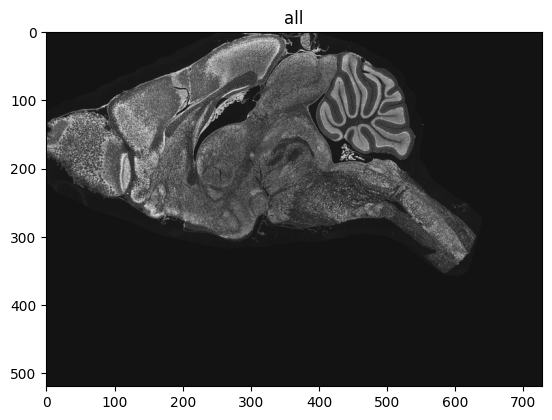

In [22]:
#arr = fixed_volume
#r = sitk.Cast(resultImage, sitk.sitkUInt16)
registered_image = sitk.GetArrayFromImage(resultImage)
plt.title('all')
plt.imshow(registered_image, cmap="gray")
plt.show()

In [ ]:
registered_image.dtype

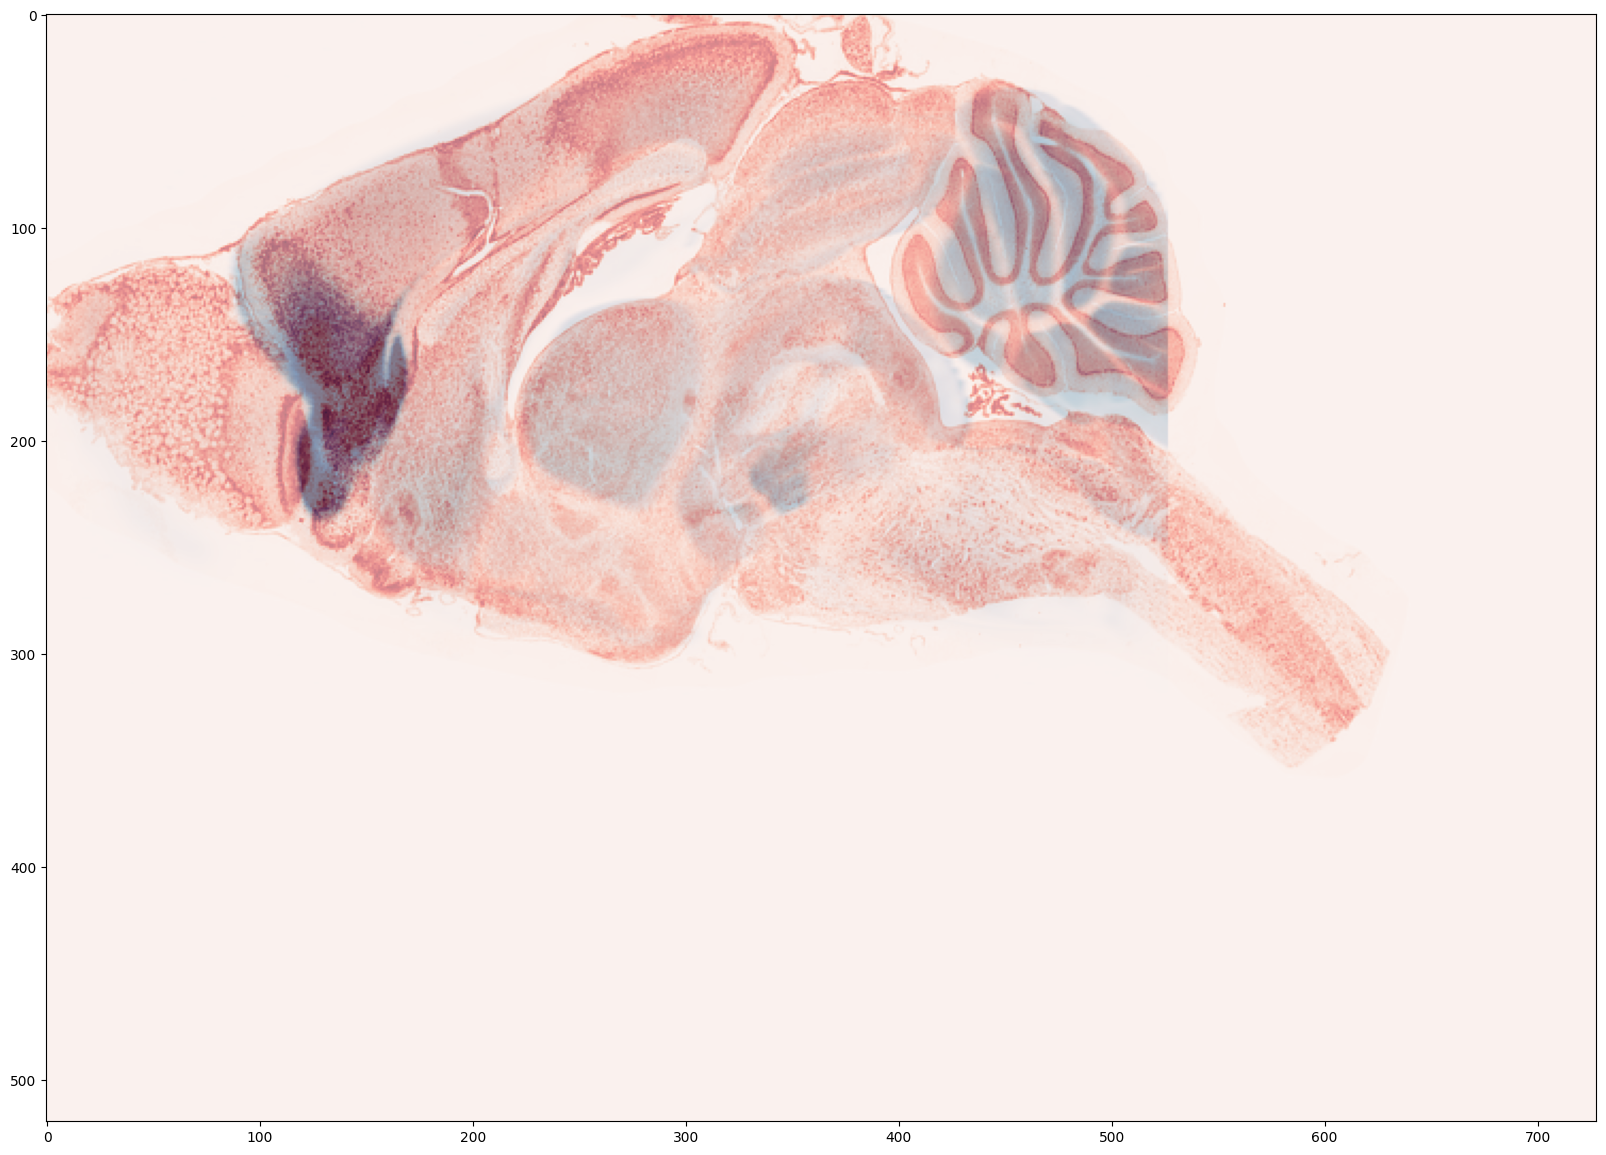

In [23]:
# 1- blue is fixed (Allen), 2 red is moving (DKXX)
compare_two_images(fixed_image, registered_image)

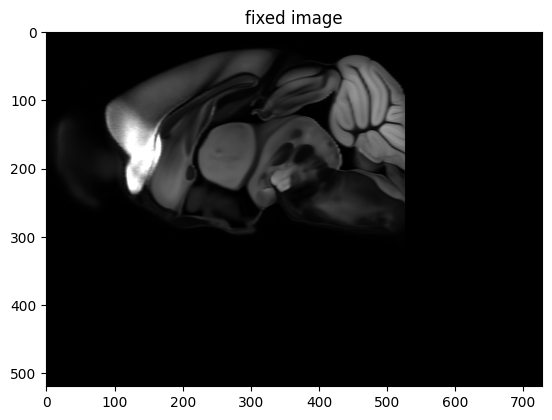

In [18]:
plt.title('fixed image')
plt.imshow(fixed_image, cmap="gray")
plt.show()

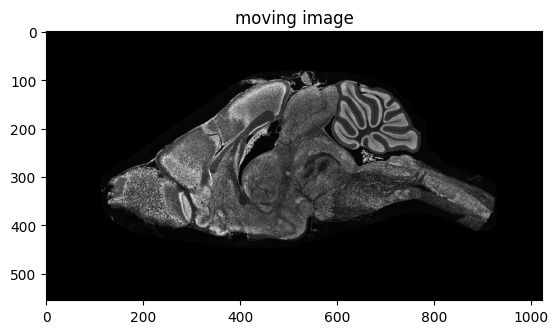

In [11]:
plt.title('moving image')
plt.imshow(moving_image, cmap="gray")
plt.show()

In [ ]:
ri = sitk.GetArrayFromImage(resultImage)
plt.title('registered image')
plt.imshow(ri, cmap="gray")
plt.show()

In [ ]:
#scaled = zoom(moving_volume, zoom=(1, scaler, scaler))
#print(scaled.shape)
outpath = os.path.join(DATA, 'registered_243.allparams.tif')
imwrite(outpath, registered_image)
#vm2 = np.swapaxes(volume, 0,2)
#print(vm2.shape)
#outpath = os.path.join(DATA, 'allen_50um_sagittal.tif')
#imwrite(outpath, vm2)

In [ ]:
result_image_affine, result_transform_parameters = itk.elastix_registration_method(fixed, moving, parameter_object = parameter_object, log_to_console=True)
